# StatCan Data on International and Domestic postsecondary institution (PSI) student enrolment, Academic Years (AY) 2009/10 - 2022/23, Full-time (FT) students only

Current Goal: Successfully created my preprocessing pipeline, now I will apply it through the international student data and credentials data (20 Jan 2024)

Pipeline is for **transforming** data, not presentation (graphs are out but deleting columns/renaming/lambda function ok)

We would probably use a custom transformer for these and pipeline from those transformations

## Imports and setup, Domestic Students first

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# for the preprocessing pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [253]:
# Reading in the CSV
df = pd.read_csv("/Users/thomasdoherty/Desktop/canadian-psi-project/psi_data/statcan_data/statcan-FT-canadian-09-23.csv", encoding='utf-8')

In [254]:
df.sample(5)

REF_DATE                                                GEO DGUID  \
2118  2014/2015  George Brown College of Applied Arts and Techn...   NaN   
48    2015/2016  College of the North Atlantic, Newfoundland an...   NaN   
2530  2019/2020     L'École Technique et Professionnelle, Manitoba   NaN   
1318  2019/2020     Collège Ellis, campus de Drummondville, Quebec   NaN   
1360  2012/2013            École de Musique Vincent d'Indy, Quebec   NaN   

             Field of study         Program type         Credential type  \
2118  Total, field of study  Total, program type  Total, credential type   
48    Total, field of study  Total, program type  Total, credential type   
2530  Total, field of study  Total, program type  Total, credential type   
1318  Total, field of study  Total, program type  Total, credential type   
1360  Total, field of study  Total, program type  Total, credential type   

              Institution type Registration status  \
2118  Total, institution type    Full-time student   
48    Total, institution type    Full-time student   
2530  Total, institution type    Full-time student   
1318  Total, institution type    Full-time student   
1360  Total, institution type    Full-time student   

     Status of student in Canada         Gender  ... UOM_ID  SCALAR_FACTOR  \
2118           Canadian students  Total, gender  ...    223          units   
48             Canadian students  Total, gender  ...    223          units   
2530           Canadian students  Total, gender  ...    223          units   
1318           Canadian students  Total, gender  ...    223          units   
1360           Canadian students  Total, gender  ...    223          units   

     SCALAR_ID       VECTOR         COORDINATE  VALUE  STATUS  SYMBOL  \
2118         0  v1613121677  156.1.1.1.1.2.2.1  18240     NaN     NaN   
48           0  v1608839696    4.1.1.1.1.2.2.1   5496     NaN     NaN   
2530         0  v1614230010  187.1.1.1.1.2.2.1    141     NaN     NaN   
1318         0  v1611172601   96.1.1.1.1.2.2.1    519     NaN     NaN   
1360         0  v1611190697  100.1.1.1.1.2.2.1     75     NaN     NaN   

      TERMINATED  DECIMALS  
2118         NaN         0  
48           NaN         0  
2530         NaN         0  
1318         NaN         0  
1360         NaN         0  

[5 rows x 21 columns]

Next Cell - confirm this data is full-time Canadian students only

In [255]:
# check type of entry in the Student Status column - only Canadian students
print(df['Status of student in Canada'].value_counts())
print("\n")
# check type of entry & values for registration status - only FT no part time records here
print(df['Registration status'].value_counts())

Status of student in Canada
Canadian students    3488
Name: count, dtype: int64


Registration status
Full-time student    3488
Name: count, dtype: int64


Check the column names - it seems to have lots of columns which aren't providing info we need

In [256]:
print(df.columns)

Index(['REF_DATE', 'GEO', 'DGUID', 'Field of study', 'Program type',
       'Credential type', 'Institution type', 'Registration status',
       'Status of student in Canada', 'Gender', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')


Lots of unnecessary columns we can remove including Registration Status as it is exclusively FT students. This notebook is examining the international / domestic splits in particular, many columns simply 'total x' where x is another demographic being explored elsewhere, so the columns can be removed here.

In previous versions I did processing steps individually but I have made them into a pipeline here now:

### Data Preprocessing Pipeline

**Dropping unnecessary columns, reformat the Year column, rename columns of interest**. Using custom transformers to preprocess the data, not ColumnTransformer (from sklearn).


Why Custom transformers?
- These operations like renaming columns, dropping columns are global transformations on the dataframe, not specific columns, so ColumnTransformer is not appropriate here
- The operations fundamentally change the structure of the dataframe - less columns are in the output, input data is not preserved. Again not appropriate for ColumnTransformer
- ColumnTransformer expects any operations on different columns to then end in recombining columns (preserving the dataframe structure).

Define the Custom Transformers (CT):

In [257]:
# Custom transformer (CT) for dropping unnecessary columns from the dataframe
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None): # this transformer isn't learning the data, so we just return self
        return self

    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore') # no inplace=True - not modifying the original dataframe; errors='ignore' to ignore named columns that don't exist in the dataframe
    
# CT for renaming columns
class RenameColumns(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names

    def fit(self, X, y=None): # as above, this transformer isn't learning the data, just return self
        return self

    def transform(self, X):
        return X.rename(columns=self.column_names)

# CT to Reformat the 'REF_DATE' (now FY Start) column to only include the year (from 2009-2010 to 2009)
class FormatDate(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None): # as above
        return self

    def transform(self, X):
        X[self.column] = X[self.column].apply(lambda x: int(x[:4]))
        return X
    
# CT to extract institution name and province from 'GEO' (now School/Locality) column
class AddInstitutionAndProvince(BaseEstimator, TransformerMixin):
    def __init__(self, column, institution_col, province_col, provinces):
        self.column = column
        self.institution_col = institution_col
        self.province_col = province_col
        self.provinces = set(provinces)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()  # Avoid in-place modification
        # Extract institution name
        X[self.institution_col] = X[self.column].apply(
            lambda x: f"{x} (total)" if x in self.provinces else x.rsplit(',', 1)[0]
        )
        # Extract province
        X[self.province_col] = X[self.column].apply(
            lambda x: x if x in self.provinces else x.rsplit(',', 1)[-1].strip()
        )
        return X
    
# CT to abbreviate institution names
class AbbreviateInstitutionNames(BaseEstimator, TransformerMixin):
    def __init__(self, column, replacements):
        """
        :param column: The column to clean up.
        :param replacements: A dictionary of strings to replace (key: target, value: replacement).
        """
        self.column = column
        self.replacements = replacements

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()  # Avoid in-place modifications
        for target, replacement in self.replacements.items():
            X[self.column] = X[self.column].str.replace(target, replacement, regex=False)
        return X


In [258]:
# Define provinces list
provinces_territories_ca = [
    "Alberta", "British Columbia", "Manitoba", "New Brunswick", "Newfoundland and Labrador",
    "Nova Scotia", "Ontario", "Prince Edward Island", "Quebec", "Saskatchewan",
    "Northwest Territories", "Nunavut", "Yukon", "Canada"
]

# Define replacements for abbreviations and clean-ups
abbreviations = {
    " of Applied Arts and Technology": "",
    " d'art appliqués et de technologie": "",
    " d'arts appliqués et de technologies": "",
    " Institute of Technology and Advanced Learning": "",
    " Community College": " CC",  # Abbreviate to "CC"
    "University": "U", # Abbreviate University
    "Université": "U", # Abbreviate Université
    "British Columbia": "BC",
}

# Define the pipeline
preprocess_pipeline = Pipeline(steps=[
    # 1. Rename necessary columns
    ('rename_columns', RenameColumns(column_names={
        "REF_DATE": "FY Start",
        "VALUE": "Enrolment",
        "Status of student in Canada": "Canadian Status"
    })),

    # 2. Format the 'FY Start' column
    ('format_date', FormatDate(column='FY Start')),

    # 3. Add Institution Name and Province columns
    ('add_institution_and_province', AddInstitutionAndProvince(
        column='GEO',  # Use GEO without renaming
        institution_col='Institution Name', 
        province_col='Province/Territory', 
        provinces=provinces_territories_ca
    )),

    # 4. Abbreviate institution names
    ('abbreviate_institution_names', AbbreviateInstitutionNames(
        column='Institution Name', 
        replacements=abbreviations
    )),

    # 5. Drop unnecessary columns, including GEO
    ('drop_columns', DropColumns(columns=['GEO', 'DGUID', 'Field of study', 'Program type',
                                           'Registration status', 'Credential type', 'Institution type',
                                           'Gender', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR',
                                           'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']))
])

### Apply the pipeline

In [259]:
processed_df = preprocess_pipeline.fit_transform(df)

In [260]:
processed_df

FY Start    Canadian Status  Enrolment        Institution Name  \
0         2009  Canadian students    1295745          Canada (total)   
1         2010  Canadian students    1333188          Canada (total)   
2         2011  Canadian students    1353324          Canada (total)   
3         2012  Canadian students    1366443          Canada (total)   
4         2013  Canadian students    1378959          Canada (total)   
...        ...                ...        ...                     ...   
3483      2018  Canadian students        693  Nunavut Arctic College   
3484      2019  Canadian students        750  Nunavut Arctic College   
3485      2020  Canadian students        843  Nunavut Arctic College   
3486      2021  Canadian students        873  Nunavut Arctic College   
3487      2022  Canadian students        783  Nunavut Arctic College   

     Province/Territory  
0                Canada  
1                Canada  
2                Canada  
3                Canada  
4                Canada  
...                 ...  
3483            Nunavut  
3484            Nunavut  
3485            Nunavut  
3486            Nunavut  
3487            Nunavut  

[3488 rows x 5 columns]

In [261]:
processed_df['Institution Name'].value_counts()

Institution Name
Canada (total)                 14
Georgian College               14
Mohawk College                 14
Niagara College Canada         14
Lambton College                14
                               ..
Collège d'Alfred                4
Yukon U                         3
U de Hearst                     2
U de l'Ontario français         2
North West Regional College     2
Name: count, Length: 260, dtype: int64

In [262]:
# check for nulls in institution name and province columns - any mistakes in the pipeline will show up here
print(f"Nulls in 'Institution Name': {processed_df['Institution Name'].isnull().sum()}")
print(f"Nulls in 'Province': {processed_df['Province/Territory'].isnull().sum()}")

Nulls in 'Institution Name': 0
Nulls in 'Province': 0


In [263]:
processed_df.sample(5)

FY Start    Canadian Status  Enrolment  \
2603      2022  Canadian students        438   
866       2013  Canadian students       5133   
58        2011  Canadian students       5262   
2114      2010  Canadian students      16425   
3073      2014  Canadian students       2049   

                                     Institution Name    Province/Territory  
2603                   Carlton Trail Regional College          Saskatchewan  
866   Champlain Regional College - St. Lambert Campus                Quebec  
58                       Prince Edward Island (total)  Prince Edward Island  
2114                             George Brown College               Ontario  
3073                                 U of Northern BC      British Columbia

## Domestic: Canada nationwide enrolment 09/10 - 22/23

In [264]:
canada_dom = processed_df[processed_df['Province/Territory'] == 'Canada']

canada_dom

FY Start    Canadian Status  Enrolment Institution Name Province/Territory
0       2009  Canadian students    1295745   Canada (total)             Canada
1       2010  Canadian students    1333188   Canada (total)             Canada
2       2011  Canadian students    1353324   Canada (total)             Canada
3       2012  Canadian students    1366443   Canada (total)             Canada
4       2013  Canadian students    1378959   Canada (total)             Canada
5       2014  Canadian students    1366716   Canada (total)             Canada
6       2015  Canadian students    1355496   Canada (total)             Canada
7       2016  Canadian students    1360779   Canada (total)             Canada
8       2017  Canadian students    1365513   Canada (total)             Canada
9       2018  Canadian students    1361304   Canada (total)             Canada
10      2019  Canadian students    1349823   Canada (total)             Canada
11      2020  Canadian students    1357824   Canada (total)             Canada
12      2021  Canadian students    1347282   Canada (total)             Canada
13      2022  Canadian students    1320684   Canada (total)             Canada

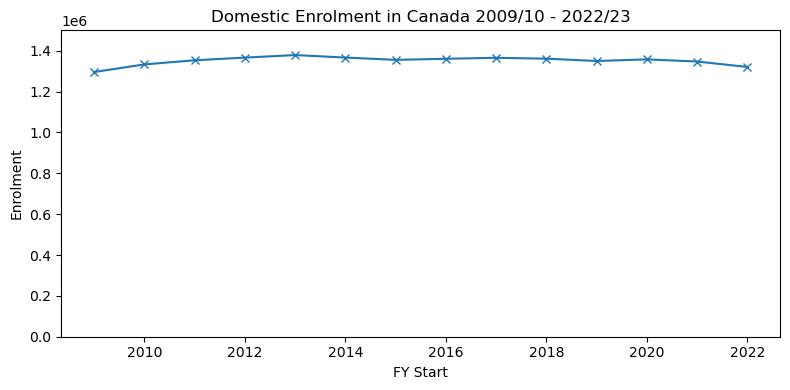

In [265]:
# plot Enrolment on y axis against FY start on x axis
plt.figure(figsize=(8, 4))
plt.plot(canada_dom['FY Start'], canada_dom['Enrolment'], marker='x')
plt.title('Domestic Enrolment in Canada 2009/10 - 2022/23')
plt.xlabel('FY Start')
plt.ylabel('Enrolment')
plt.ylim(0, 1500000)

plt.tight_layout()
plt.show()

## Domestic: Provincial enrolment 09/10 - 22/23

Start with filtering for only the total figures at the provincial level, graph the big provinces together & small ones separate for visibility

In [266]:
# Filter out records from Canada Domestic - only records with province (total) in Institution Name
provinces_df = processed_df[(processed_df['Institution Name'].str.contains(r'\(total\)')) & (processed_df['Province/Territory'] != 'Canada')]

Check the df - only Provincial totals

In [267]:
# Display the unique institution names - should only be provincial totals
print(provinces_df['Institution Name'].unique())

# display the unique provinces - should only be provinces, no '(total)'
print(provinces_df['Province/Territory'].unique())

['Newfoundland and Labrador (total)' 'Prince Edward Island (total)'
 'Nova Scotia (total)' 'New Brunswick (total)' 'Quebec (total)'
 'Ontario (total)' 'Manitoba (total)' 'Saskatchewan (total)'
 'Alberta (total)' 'BC (total)' 'Yukon (total)'
 'Northwest Territories (total)' 'Nunavut (total)']
['Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut']


Will be useful for other graphs - Cell below, group larger provinces together away from smaller provinces for easier visuals when plotting.

In [268]:
# Define the provinces and territories for the three separate graphs
large_population_provinces = ["Ontario", "Quebec", "Alberta", "British Columbia"]
territories = ["Yukon", "Northwest Territories", "Nunavut"]
other_provinces = [
    province for province in provinces_df['Province/Territory'].unique()
    if province not in large_population_provinces and province not in territories
]

In [269]:
import plotly.graph_objects as go

# Function to create a plotly figure for a group of provinces or territories
def create_interactive_plot(title, group_data, group_name):
    fig = go.Figure()

    for region in group_data[group_name].unique():
        region_data = group_data[group_data[group_name] == region]

        # Add line plot with markers
        fig.add_trace(go.Scatter(
            x=region_data['FY Start'],
            y=region_data['Enrolment'],
            mode='lines+markers',
            name=region,
            marker=dict(symbol='x', size=6)
        ))

    # Update layout to include a title, axis labels, and legend position
    fig.update_layout(
        title=title,
        xaxis_title="FY Start",
        yaxis_title="Enrolment",
        legend_title=group_name,
        legend=dict(
            orientation="v",
            x=1.05,  # Move legend outside the plotting area
            y=1,     # Align with top of the figure
        ),
        height=600,
        width=1300,
        margin=dict(l=50, r=150, t=50, b=50)
    )

    return fig

# Large provinces graph
large_provinces_fig = create_interactive_plot(
    "Domestic Enrolment 2012-2021 - Large Provinces",
    provinces_df[provinces_df['Province/Territory'].isin(large_population_provinces)],
    "Province/Territory"
)
large_provinces_fig.show()

# Other provinces graph
other_provinces_fig = create_interactive_plot(
    "Domestic Enrolment 2012-2021 - Other Provinces",
    provinces_df[provinces_df['Province/Territory'].isin(other_provinces)],
    "Province/Territory"
)
other_provinces_fig.show()

# Territories graph
territories_fig = create_interactive_plot(
    "Domestic Enrolment 2012-2021 - Territories",
    provinces_df[provinces_df['Province/Territory'].isin(territories)],
    "Province/Territory"
)
territories_fig.show()


## Domestic: School-level enrolment 09/10 - 22/23

In [270]:
# Filter out records of provincial and national totals
psi_dom = processed_df[~processed_df['Institution Name'].str.contains(r'\(total\)')]

psi_dom

FY Start    Canadian Status  Enrolment            Institution Name  \
28        2009  Canadian students      14298  Memorial U of Newfoundland   
29        2010  Canadian students      14196  Memorial U of Newfoundland   
30        2011  Canadian students      14097  Memorial U of Newfoundland   
31        2012  Canadian students      13923  Memorial U of Newfoundland   
32        2013  Canadian students      13611  Memorial U of Newfoundland   
...        ...                ...        ...                         ...   
3483      2018  Canadian students        693      Nunavut Arctic College   
3484      2019  Canadian students        750      Nunavut Arctic College   
3485      2020  Canadian students        843      Nunavut Arctic College   
3486      2021  Canadian students        873      Nunavut Arctic College   
3487      2022  Canadian students        783      Nunavut Arctic College   

             Province/Territory  
28    Newfoundland and Labrador  
29    Newfoundland and Labrador  
30    Newfoundland and Labrador  
31    Newfoundland and Labrador  
32    Newfoundland and Labrador  
...                         ...  
3483                    Nunavut  
3484                    Nunavut  
3485                    Nunavut  
3486                    Nunavut  
3487                    Nunavut  

[3292 rows x 5 columns]

In [271]:
# Check institution names greater than 40 characters - see how we can abbreviate them
long_institution_names = psi_dom[psi_dom['Institution Name'].str.len() > 40]
print(long_institution_names['Institution Name'].unique())

['Collège Communautaire du Nouveau-Brunswick'
 'New Brunswick College of Craft and Design'
 "École nationale d'administration publique"
 'Institut national de la recherche scientifique'
 'Champlain Regional College - St. Lambert Campus'
 "Institut de tourisme et d'hôtellerie du Québec"
 "CÉGEP régional de Lanaudière à L'Assomption"
 'École de sténographie judiciaire du Québec'
 'CÉGEP régional de Lanaudière à Terrebonne'
 'Collège dominicain de philosophie et de théologie'
 "La Cité collégiale d'arts appliqués et de technologie"
 'Kemptville College of Agricultural Technology'
 'Providence U College and Theological Seminary'
 'Manitoba Institute of Trades and Technology']


In [272]:
import plotly.graph_objects as go

# Get the unique provinces/territories from the dataframe
unique_provinces = psi_dom['Province/Territory'].unique()

# Iterate over each province to create separate interactive graphs
for province in unique_provinces:
    # Filter the data for the current province/territory
    province_data = psi_dom[psi_dom['Province/Territory'] == province]

    # Filter Quebec data for enrolment >= 2000 to improve readability
    if province == "Quebec":
        province_data = province_data[province_data['Enrolment'] >= 2000]

    # Create a Plotly figure for the current province
    fig = go.Figure()

    # Plot enrolment trends for each school in the current province/territory
    for school in province_data['Institution Name'].unique():
        school_data = province_data[province_data['Institution Name'] == school]
        fig.add_trace(go.Scatter(
            x=school_data['FY Start'],
            y=school_data['Enrolment'],
            mode='lines+markers',
            name=school,
            marker=dict(symbol='x', size=6)
        ))

    # Set the title and labels
    fig.update_layout(
        title=f'Domestic Enrolment in {province}',
        xaxis_title='FY Start',
        yaxis_title='Enrolment',
        legend_title='Schools',
        legend=dict(
            orientation='v',
            x=1.05,  # Move legend outside the plotting area (right side)
            y=1,     # Align legend with the top of the figure
        ),
        height=600,
        width=1300,
        margin=dict(l=50, r=150, t=50, b=50)  # Adjust right margin to accommodate the legend
    )

    # Show the figure
    fig.show()


## International: Reading in data & preprocess pipeline

In [273]:
# Reading the CSV
df_intl = pd.read_csv("/Users/thomasdoherty/Desktop/canadian-psi-project/psi_data/statcan_data/statcan-FT-intl-09-23.csv", encoding='utf-8')

In [274]:
df_intl.sample(5)

REF_DATE                                            GEO        DGUID  \
2878  2022/2023                               British Columbia  2021A000259   
3031  2009/2010      Northern Lights College, British Columbia          NaN   
200   2009/2010  Nova Scotia Agricultural College, Nova Scotia          NaN   
1888  2019/2020                       York University, Ontario          NaN   
2472  2022/2023         Saskatchewan Polytechnic, Saskatchewan          NaN   

             Field of study         Program type         Credential type  \
2878  Total, field of study  Total, program type  Total, credential type   
3031  Total, field of study  Total, program type  Total, credential type   
200   Total, field of study  Total, program type  Total, credential type   
1888  Total, field of study  Total, program type  Total, credential type   
2472  Total, field of study  Total, program type  Total, credential type   

              Institution type Registration status  \
2878  Total, institution type    Full-time student   
3031  Total, institution type    Full-time student   
200   Total, institution type    Full-time student   
1888  Total, institution type    Full-time student   
2472  Total, institution type    Full-time student   

     Status of student in Canada         Gender  ... UOM_ID  SCALAR_FACTOR  \
2878      International students  Total, gender  ...    223          units   
3031      International students  Total, gender  ...    223          units   
200       International students  Total, gender  ...    223          units   
1888      International students  Total, gender  ...    223          units   
2472      International students  Total, gender  ...    223          units   

     SCALAR_ID       VECTOR         COORDINATE  VALUE  STATUS  SYMBOL  \
2878         0  v1615253227  226.1.1.1.1.2.3.1  53583     NaN     NaN   
3031         0  v1616007012  238.1.1.1.1.2.3.1      0     NaN     NaN   
200          0  v1609314188   16.1.1.1.1.2.3.1     93     NaN     NaN   
1888         0  v1612605303  143.1.1.1.1.2.3.1   9174     NaN     NaN   
2472         0  v1614534814  191.1.1.1.1.2.3.1   1782     NaN     NaN   

      TERMINATED  DECIMALS  
2878         NaN         0  
3031         NaN         0  
200          NaN         0  
1888         NaN         0  
2472         NaN         0  

[5 rows x 21 columns]

Test pipeline for one-line pre-processing of this data:

In [275]:
processed_df_intl = preprocess_pipeline.fit_transform(df_intl)

In [276]:
processed_df_intl.sample(5)

FY Start         Canadian Status  Enrolment  \
1945      2016  International students         42   
2225      2016  International students       4032   
1536      2011  International students          9   
669       2010  International students          9   
1997      2012  International students       3498   

                        Institution Name Province/Territory  
1945                      Collège Boréal            Ontario  
2225                      Seneca College            Ontario  
1536  Collège O'Sullivan de Montréal inc             Quebec  
669            CÉGEP de Bois-de-Boulogne             Quebec  
1997                  Centennial College            Ontario

## International: Canada nationwide enrolment 09/10 - 22/23

In [277]:
#filter the dataframe for Canada national records only
canada_intl = processed_df_intl[processed_df_intl['Province/Territory'] == 'Canada']

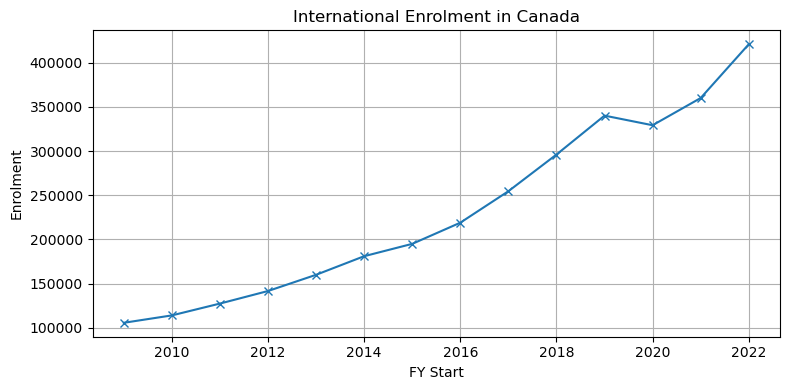

In [278]:
# plot Enrolment on y axis against FY start on x axis

plt.figure(figsize=(8, 4))
plt.plot(canada_intl['FY Start'], canada_intl['Enrolment'], marker='x')
plt.title('International Enrolment in Canada')
plt.xlabel('FY Start')
plt.ylabel('Enrolment')
plt.grid(True)
plt.tight_layout()
plt.show()

Compare this trend in International Enrolment vs Domestic Enrolment:

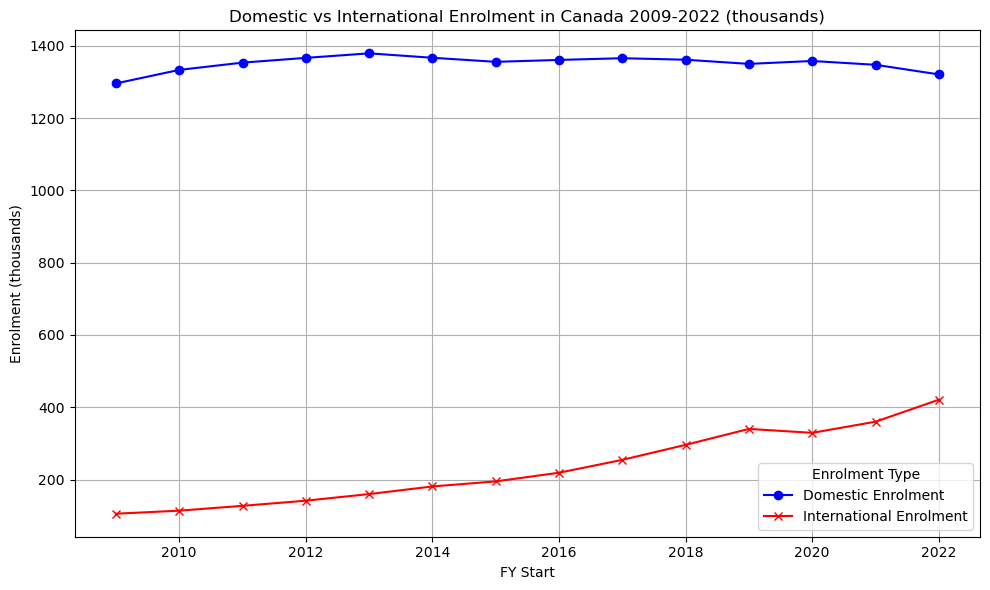

In [279]:
total_enrolment = canada_dom['Enrolment'].sum() + canada_intl['Enrolment'].sum()
intl_percentage = (canada_intl['Enrolment'].sum() / total_enrolment) * 100

# plot both domestic and international enrolment on the same graph
plt.figure(figsize=(10, 6))
plt.plot(
    canada_dom['FY Start'],
    canada_dom['Enrolment'] / 1000,
    marker='o',
    color='blue',
    label='Domestic Enrolment'
)
plt.plot(
    canada_intl['FY Start'],
    canada_intl['Enrolment'] / 1000,
    marker='x',
    color='red',
    label='International Enrolment'
)
plt.title('Domestic vs International Enrolment in Canada 2009-2022 (thousands)')
plt.xlabel('FY Start')
plt.ylabel('Enrolment (thousands)')
plt.legend(title='Enrolment Type')
plt.grid(True)
plt.tight_layout()
plt.show()


## International: Provincial enrolment 09/10 - 22/23

In [280]:
# Filter out records from Canada International - only records with province (total) in Institution Name
provinces_df_intl = processed_df_intl[(processed_df_intl['Institution Name'].str.contains(r'\(total\)')) & (processed_df_intl['Province/Territory'] != 'Canada')]

In [281]:
provinces_df_intl

FY Start         Canadian Status  Enrolment  \
14        2009  International students       1080   
15        2010  International students       1281   
16        2011  International students       1389   
17        2012  International students       1716   
18        2013  International students       1785   
...        ...                     ...        ...   
3240      2016  International students          0   
3241      2020  International students          3   
3242      2021  International students          0   
3243      2022  International students          6   
3249      2014  International students          3   

                       Institution Name         Province/Territory  
14    Newfoundland and Labrador (total)  Newfoundland and Labrador  
15    Newfoundland and Labrador (total)  Newfoundland and Labrador  
16    Newfoundland and Labrador (total)  Newfoundland and Labrador  
17    Newfoundland and Labrador (total)  Newfoundland and Labrador  
18    Newfoundland and Labrador (total)  Newfoundland and Labrador  
...                                 ...                        ...  
3240      Northwest Territories (total)      Northwest Territories  
3241      Northwest Territories (total)      Northwest Territories  
3242      Northwest Territories (total)      Northwest Territories  
3243      Northwest Territories (total)      Northwest Territories  
3249                    Nunavut (total)                    Nunavut  

[158 rows x 5 columns]

Plotting change of international student enrolment over time by the provinces - split the large provinces from the others

In [282]:
large_population_provinces = ["Ontario", "Quebec", "Alberta", "British Columbia"]
other_provinces = ["Newfoundland and Labrador", "Nova Scotia", "New Brunswick", "Manitoba", "Saskatchewan", "Prince Edward Island"]
territories = ["Yukon", "Northwest Territories", "Nunavut"]

In [283]:
print(provinces_df_intl['Province/Territory'].unique())

['Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut']


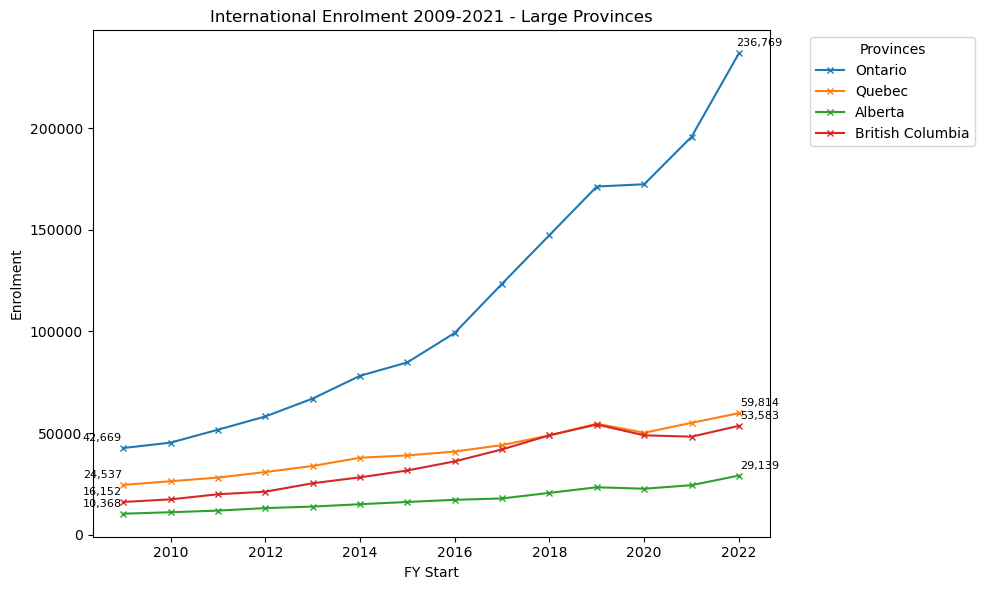

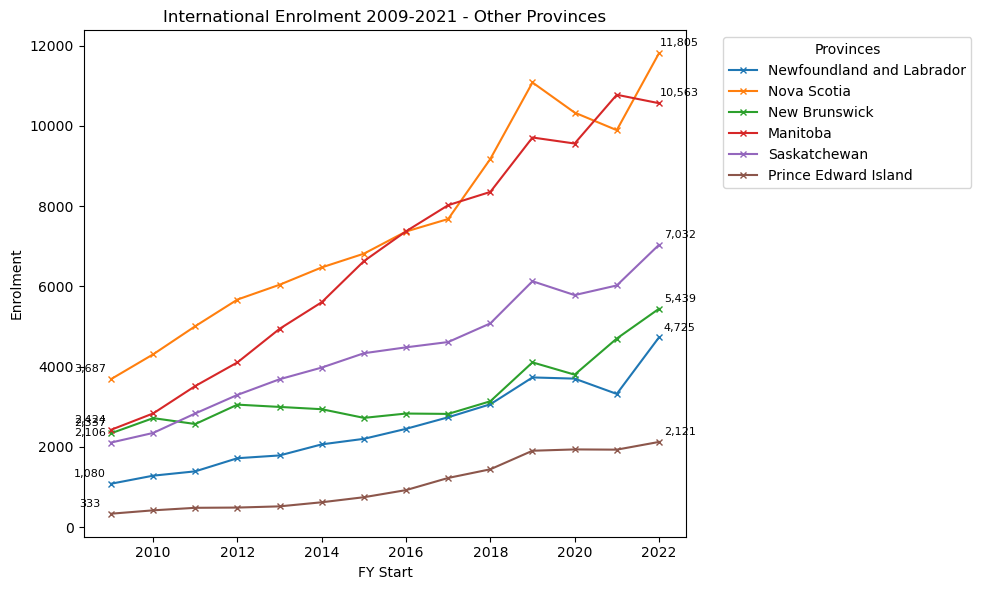

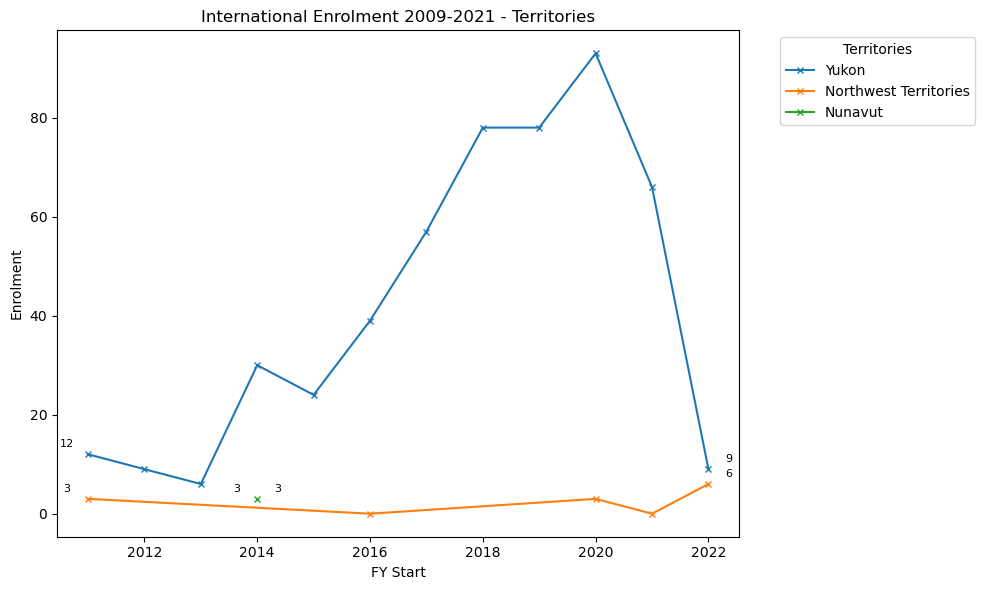

In [284]:
# Function to annotate the first and last y-values
def annotate_first_and_last_points(ax, x_data, y_data):
    if len(x_data) > 0 and len(y_data) > 0:
        # Annotate the first point
        ax.annotate(f'{y_data.iloc[0]:,.0f}', (x_data.iloc[0], y_data.iloc[0]), 
                    textcoords="offset points", xytext=(-15, 5), ha='center', fontsize=8)
        # Annotate the last point
        ax.annotate(f'{y_data.iloc[-1]:,.0f}', (x_data.iloc[-1], y_data.iloc[-1]), 
                    textcoords="offset points", xytext=(15, 5), ha='center', fontsize=8)

# Function to plot enrolment trends for a group of regions
def plot_enrolment_by_group(df, regions, title, y_label, legend_title):
    fig, ax = plt.subplots(figsize=(10, 6))
    for region in regions:
        region_data = df[df['Province/Territory'] == region]
        ax.plot(
            region_data['FY Start'],
            region_data['Enrolment'],
            label=region,
            marker='x',
            markersize=4
        )
        annotate_first_and_last_points(ax, region_data['FY Start'], region_data['Enrolment'])

    ax.set_title(title)
    ax.set_xlabel('FY Start')
    ax.set_ylabel(y_label)
    ax.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the function for each group of regions
plot_enrolment_by_group(
    provinces_df_intl, 
    large_population_provinces, 
    'International Enrolment 2009-2021 - Large Provinces', 
    'Enrolment', 
    'Provinces'
)

plot_enrolment_by_group(
    provinces_df_intl, 
    other_provinces, 
    'International Enrolment 2009-2021 - Other Provinces', 
    'Enrolment', 
    'Provinces'
)

plot_enrolment_by_group(
    provinces_df_intl, 
    territories, 
    'International Enrolment 2009-2021 - Territories', 
    'Enrolment', 
    'Territories'
)

We will **ignore the territories from here on out** - there is no point analysing single digit student information.

Compare international student vs domestic student trends below:

In [285]:

from plotly.subplots import make_subplots

# Function to create interactive plots with consistent colors for regions
def compare_enrolment_plotly(domestic_df, intl_df, regions, title):
    fig = make_subplots(rows=1, cols=1)  # Single subplot, but this can be extended for multiple if needed

    # Generate a colormap for consistent colors
    colors = px.colors.qualitative.Set1  # Use a qualitative color set for distinct region colors
    region_colors = {region: colors[i % len(colors)] for i, region in enumerate(regions)}

    for region in regions:
        # Filter data for domestic and international enrolments
        domestic_data = domestic_df[domestic_df['Province/Territory'] == region]
        intl_data = intl_df[intl_df['Province/Territory'] == region]

        # Add domestic enrolment trace
        fig.add_trace(
            go.Scatter(
                x=domestic_data['FY Start'],
                y=domestic_data['Enrolment'],
                mode='lines+markers',
                name=f'{region} (Domestic)',
                line=dict(color=region_colors[region], dash='solid'),
                marker=dict(symbol='circle', size=6),
                hoverinfo='x+y+name',
            )
        )

        # Add international enrolment trace
        fig.add_trace(
            go.Scatter(
                x=intl_data['FY Start'],
                y=intl_data['Enrolment'],
                mode='lines+markers',
                name=f'{region} (International)',
                line=dict(color=region_colors[region], dash='dash'),
                marker=dict(symbol='x', size=6),
                hoverinfo='x+y+name',
            )
        )

    # Update layout for better readability
    fig.update_layout(
        title=title,
        xaxis_title='FY Start',
        yaxis_title='Enrolment',
        legend_title='Provinces/Status',
        template='plotly_white',
        hovermode='closest',
        width=900,
        height=600,
    )

    fig.show()

# Call the function for each group of regions
compare_enrolment_plotly(
    provinces_df, 
    provinces_df_intl, 
    large_population_provinces, 
    'Enrolment Trends 2009-2022 - Large Provinces (Domestic vs International)'
)

compare_enrolment_plotly(
    provinces_df, 
    provinces_df_intl, 
    other_provinces, 
    'Enrolment Trends 2009-2022 - Other Provinces (Domestic vs International)'
)

compare_enrolment_plotly(
    provinces_df, 
    provinces_df_intl, 
    territories, 
    'Enrolment Trends 2009-2022 - Territories (Domestic vs International)'
)


## International: School-level Enrolment 09/10 - 22/23

In [286]:
# Filter out records of provincial and national totals
psi_intl = processed_df_intl[~processed_df_intl['Institution Name'].str.contains(r'\(total\)')]

psi_intl

FY Start         Canadian Status  Enrolment            Institution Name  \
28        2009  International students       1038  Memorial U of Newfoundland   
29        2010  International students       1230  Memorial U of Newfoundland   
30        2011  International students       1341  Memorial U of Newfoundland   
31        2012  International students       1650  Memorial U of Newfoundland   
32        2013  International students       1725  Memorial U of Newfoundland   
...        ...                     ...        ...                         ...   
3245      2016  International students          0              Aurora College   
3246      2020  International students          3              Aurora College   
3247      2021  International students          0              Aurora College   
3248      2022  International students          6              Aurora College   
3250      2014  International students          3      Nunavut Arctic College   

             Province/Territory  
28    Newfoundland and Labrador  
29    Newfoundland and Labrador  
30    Newfoundland and Labrador  
31    Newfoundland and Labrador  
32    Newfoundland and Labrador  
...                         ...  
3245      Northwest Territories  
3246      Northwest Territories  
3247      Northwest Territories  
3248      Northwest Territories  
3250                    Nunavut  

[3079 rows x 5 columns]

In [287]:
# divide the dataframe by unique provinces and territories, except the territories
unique_provinces_intl = psi_intl['Province/Territory'].unique()

# remove Nunavut, Northwest Territories, and Yukon from the list
unique_provinces_intl = [province for province in unique_provinces_intl if province not in territories]
print(territories)
print(unique_provinces_intl)

['Yukon', 'Northwest Territories', 'Nunavut']
['Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia']


In [288]:
import plotly.graph_objects as go

# Iterate over each province to create separate interactive graphs
for province in unique_provinces_intl:
    # Filter the data for the current province/territory
    province_data = psi_intl[psi_intl['Province/Territory'] == province]

    # Filter Quebec data for enrolment >= 2000 to improve readability
    if province == "Quebec":
        province_data = province_data[province_data['Enrolment'] >= 2000]

    # Create a Plotly figure for the current province
    fig = go.Figure()

    # Plot enrolment trends for each school in the current province/territory
    for school in province_data['Institution Name'].unique():
        school_data = province_data[province_data['Institution Name'] == school]
        fig.add_trace(go.Scatter(
            x=school_data['FY Start'],
            y=school_data['Enrolment'],
            mode='lines+markers',
            name=school,
            marker=dict(symbol='x', size=6)
        ))

    # Update the layout to include titles, axis labels, and an external legend
    fig.update_layout(
        title=f'International Enrolment in {province}',
        xaxis_title="FY Start",
        yaxis_title="Enrolment",
        legend_title="Schools",
        legend=dict(
            orientation="v",
            x=1.05,  # Move legend outside the plotting area
            y=1      # Align with top of the figure
        ),
        height=600,
        width=1300,
        margin=dict(l=50, r=150, t=50, b=50)  # Adjust right margin for legend
    )

    # Show the figure
    fig.show()


### Split Colleges up from Universities - use for later

In [289]:
# now we have a list of the colleges
college_intl['Institution Name'].unique()

array(['College of the North Atlantic', 'Holland College',
       "Collège de l'Île", 'Nova Scotia Agricultural College',
       'Nova Scotia CC (NSCC)', 'Maritime College of Forest Technology',
       'New Brunswick CC', 'Collège Communautaire du Nouveau-Brunswick',
       'New Brunswick College of Craft and Design',
       "CÉGEP d'Abitibi-Témiscamingue", "CÉGEP d'Ahuntsic",
       'CÉGEP André-Laurendeau', 'CÉGEP de Bois-de-Boulogne',
       'CÉGEP de Chicoutimi', 'Collège Dawson', 'CÉGEP de Drummondville',
       'CÉGEP Édouard-Montpetit', 'CÉGEP François-Xavier Garneau',
       'CÉGEP de la Gaspésie et des Îles', 'CÉGEP de Granby',
       'CÉGEP de Baie-Comeau', 'CÉGEP John Abbott College',
       'CÉGEP régional de Lanaudière à Joliette', 'CÉGEP de Jonquière',
       'CÉGEP de La Pocatière',
       'Champlain Regional College - St. Lambert Campus',
       'CÉGEP de Lévis-Lauzon', 'CÉGEP Limoilou', 'CÉGEP Lionel-Groulx',
       'CÉGEP de Maisonneuve', 'CÉGEP de Matane', 'CÉGEP Mon

In [290]:
university_intl['Institution Name'].unique()

array(['Memorial U of Newfoundland', 'U of Prince Edward Island',
       'Acadia U', 'Atlantic School of Theology', 'Cape Breton U',
       'Dalhousie U', "U of King's College", 'Mount Saint Vincent U',
       'NSCAD U', 'U Sainte-Anne', 'St. Francis Xavier U',
       "Saint Mary's U", 'Mount Allison U', 'U of New Brunswick',
       'U de Moncton', 'St. Thomas U', "Bishop's U", 'McGill U',
       'U de Montréal', 'U Laval', 'U de Sherbrooke', 'Concordia U',
       'U du Québec à Chicoutimi', 'U du Québec à Montréal',
       'U du Québec en Abitibi-Témiscamingue',
       'U du Québec à Trois-Rivières', 'U du Québec en Outaouais',
       "École nationale d'administration publique",
       'Institut national de la recherche scientifique',
       'U du Québec à Rimouski', 'École de technologie supérieure',
       'Télé-université', 'Conservatoire Lassalle',
       "École de Musique Vincent d'Indy", 'Institut Teccart inc.',
       'Campus Notre-Dame-de-Foy', 'Séminaire de Sherbrooke',
     

In [291]:
college_intl.sample(10)

FY Start         Canadian Status  Enrolment  \
1183      2021  International students          3   
1572      2019  International students         18   
369       2017  International students        261   
2223      2014  International students       3099   
913       2016  International students         63   
1378      2012  International students         18   
2114      2017  International students       2271   
1285      2013  International students          6   
1681      2012  International students         15   
1991      2020  International students       3954   

                                       Institution Name Province/Territory  \
1183                               CÉGEP de Valleyfield             Quebec   
1572                                 CÉGEP Gérald-Godin             Quebec   
369          Collège Communautaire du Nouveau-Brunswick      New Brunswick   
2223                                     Seneca College            Ontario   
913                                CÉGEP de Maisonneuve             Quebec   
1378                                   Collège Laflèche             Quebec   
2114                                     Mohawk College            Ontario   
1285             Collège Centennal / Centennial College             Quebec   
1681  Collège dominicain de philosophie et de théologie            Ontario   
1991                                   Cambrian College            Ontario   

       YOY Growth  
1183   -66.666667  
1572    20.000000  
369    -17.142857  
2223  2052.083333  
913     -4.545455  
1378   -33.333333  
2114    37.386570  
1285   100.000000  
1681   -16.666667  
1991    28.585366

## YoY Growth Rates: Comparing Domestic vs International, College vs University

Beginning at national level we can find the year-on-year (YoY) growth rates for the international and domestic enrolment

Because of the impact of COVID on enrolment particularly in 2020/21 but also 21/22, we will split the last three years (20/21, 21/22 and 22/23) where appropriate.

### National YoY Enrolment Change

In [292]:
#show first 5 records of the canada_dom and canada_intl dataframe
print(canada_dom.head(), '\n\n', canada_intl.head())

   FY Start    Canadian Status  Enrolment Institution Name Province/Territory
0      2009  Canadian students    1295745   Canada (total)             Canada
1      2010  Canadian students    1333188   Canada (total)             Canada
2      2011  Canadian students    1353324   Canada (total)             Canada
3      2012  Canadian students    1366443   Canada (total)             Canada
4      2013  Canadian students    1378959   Canada (total)             Canada 

    FY Start         Canadian Status  Enrolment Institution Name  \
0      2009  International students     105702   Canada (total)   
1      2010  International students     114072   Canada (total)   
2      2011  International students     127467   Canada (total)   
3      2012  International students     141675   Canada (total)   
4      2013  International students     160038   Canada (total)   

  Province/Territory  
0             Canada  
1             Canada  
2             Canada  
3             Canada  
4          

In [ ]:
# plot domestic vs international enrolment for canada in plotly - TBC
fig = go.Figure()

# add domestic enrolment trace
fig.add_trace(go.Scatter(
    x=canada_dom['FY Start'],
    y=canada_dom['Enrolment'],
    mode='lines+markers',
    name='Domestic Enrolment',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle', size=6),
    hoverinfo='x+y+name'
))

# add international enrolment trace
fig.add_trace(go.Scatter(
    x=canada_intl['FY Start'],
    y=canada_intl['Enrolment'],
    mode='lines+markers',
    name='International Enrolment',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x', size=6),
    hoverinfo='x+y+name'
))

# update layout for better readability
fig.update_layout(
    title='Domestic vs International Enrolment in Canada',
    xaxis_title='FY Start',
    yaxis_title='Enrolment',
    legend_title='Enrolment Type',
    template='plotly_white',
    hovermode='closest',
    width=900,
    height=600
)

fig.show()


#### Exponential or Linear shape?

Is international enrolment more linear or exponential in nature?

For the whole 2009-2022 period:

In [294]:
# plot the growth with a linear regression line and R^2 value
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Linear regression
# Extract x and y values
x = canada_intl['FY Start'].values.reshape(-1, 1)  # FY Start as x (reshape for sklearn)
y = canada_intl['Enrolment'].values

# Linear regression
linear_model = LinearRegression()
linear_model.fit(x, y)
linear_pred = linear_model.predict(x)
linear_r2 = r2_score(y, linear_pred)

print(f"Linear fit of 09/10 - 22/23 data is {linear_r2:.3f}")

# Exponential
log_y = np.log(y)  # Transform y for exponential regression
exp_model = LinearRegression()
exp_model.fit(x, log_y)
exp_pred_log = exp_model.predict(x)
exp_pred = np.exp(exp_pred_log)  # Transform back to original scale
exp_r2 = r2_score(y, exp_pred)

print(f"Exponential fit of 09/10 - 22/23 data is {exp_r2:.3f}")

Linear fit of 09/10 - 22/23 data is 0.965
Exponential fit of 09/10 - 22/23 data is 0.983


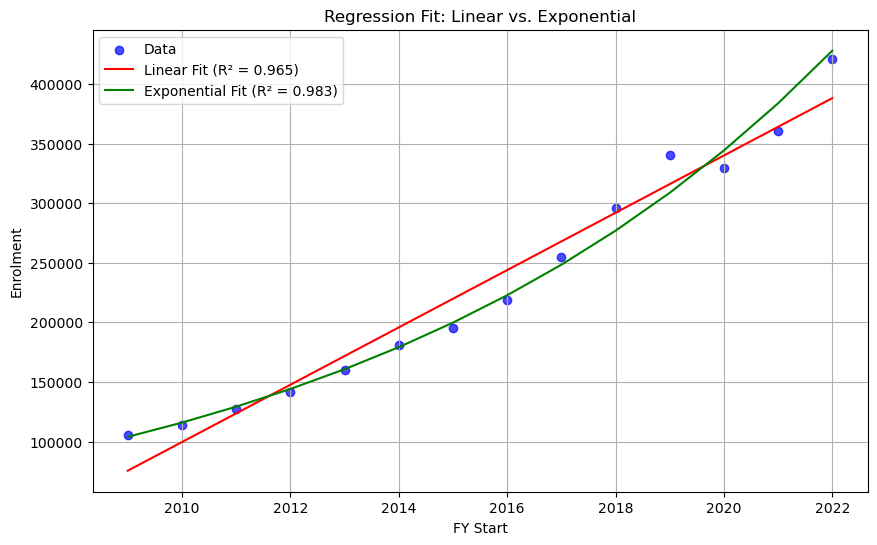

Linear R²: 0.965
Exponential R²: 0.983


In [295]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(canada_intl['FY Start'], y, label="Data", color='blue', alpha=0.7)
plt.plot(canada_intl['FY Start'], linear_pred, label=f"Linear Fit (R² = {linear_r2:.3f})", color='red')
plt.plot(canada_intl['FY Start'], exp_pred, label=f"Exponential Fit (R² = {exp_r2:.3f})", color='green')
plt.xlabel('FY Start')
plt.ylabel('Enrolment')
plt.title('Regression Fit: Linear vs. Exponential')
plt.legend()
plt.grid()
plt.show()

# Results
print(f"Linear R²: {linear_r2:.3f}")
print(f"Exponential R²: {exp_r2:.3f}")

Isolate the 2020, 2021, 2022 data points, as COVID halted progress.

In [296]:
# create filter for pre-covid years and post-covid years
pre_covid_canada_intl = canada_intl[canada_intl['FY Start'] < 2020]
post_covid_canada_intl = canada_intl[canada_intl['FY Start'] >= 2020]

In [297]:
pre_covid_canada_intl.head()

FY Start         Canadian Status  Enrolment Institution Name  \
0      2009  International students     105702   Canada (total)   
1      2010  International students     114072   Canada (total)   
2      2011  International students     127467   Canada (total)   
3      2012  International students     141675   Canada (total)   
4      2013  International students     160038   Canada (total)   

  Province/Territory  
0             Canada  
1             Canada  
2             Canada  
3             Canada  
4             Canada

In [298]:
# model the pre-covid years
# Linear regression 
x = pre_covid_canada_intl['FY Start'].values.reshape(-1, 1)  # FY Start as x (reshape for sklearn)
y = pre_covid_canada_intl['Enrolment'].values

# Linear regression
linear_model = LinearRegression()
linear_model.fit(x, y)
linear_pred = linear_model.predict(x)
linear_r2 = r2_score(y, linear_pred)

print(f"Linear fit of Pre-Covid 09/10 - 19/20 data is {linear_r2:.3f}")

# Exponential
log_y = np.log(y)  # Transform y for exponential regression
exp_model = LinearRegression()
exp_model.fit(x, log_y)
exp_pred_log = exp_model.predict(x)
exp_pred = np.exp(exp_pred_log)  # Transform back to original scale
exp_r2 = r2_score(y, exp_pred)

print(f"Exponential fit of Pre-Covid 09/10 - 19/20 data is {exp_r2:.3f}")

Linear fit of Pre-Covid 09/10 - 19/20 data is 0.945
Exponential fit of Pre-Covid 09/10 - 19/20 data is 0.991


In [299]:
# model the post-covid years
# Linear regression 
x = post_covid_canada_intl['FY Start'].values.reshape(-1, 1)  # FY Start as x (reshape for sklearn)
y = post_covid_canada_intl['Enrolment'].values

# Linear regression
linear_model = LinearRegression()
linear_model.fit(x, y)
linear_pred = linear_model.predict(x)
linear_r2 = r2_score(y, linear_pred)

print(f"Linear fit of Post-Covid 20/21 - 22/23 data is {linear_r2:.3f}")

# Exponential
log_y = np.log(y)  # Transform y for exponential regression
exp_model = LinearRegression()
exp_model.fit(x, log_y)
exp_pred_log = exp_model.predict(x)
exp_pred = np.exp(exp_pred_log)  # Transform back to original scale
exp_r2 = r2_score(y, exp_pred)

print(f"Exponential fit of Post-Covid 20/21 - 22/23 data is {exp_r2:.3f}")

Linear fit of Post-Covid 20/21 - 22/23 data is 0.965
Exponential fit of Post-Covid 20/21 - 22/23 data is 0.977


As we can see in two cells above, the pre-covid years model much better for an exponential growth of international students before Covid-19 put a dent in enrolment but only temporarily, with just three Covid/post-Covid data points it is still more closely resembling the exponential model, just less so than pre-Covid,.

#### Growth rate YoY pre and post-covid

It's quite clear that Covid interrupted the growth rate so if we separate the data before (2009 - 2019) and after (2020 onwards) We can find year-on-year growth rates

In [300]:
pre_covid_canada_intl

FY Start         Canadian Status  Enrolment Institution Name  \
0       2009  International students     105702   Canada (total)   
1       2010  International students     114072   Canada (total)   
2       2011  International students     127467   Canada (total)   
3       2012  International students     141675   Canada (total)   
4       2013  International students     160038   Canada (total)   
5       2014  International students     181086   Canada (total)   
6       2015  International students     195063   Canada (total)   
7       2016  International students     219018   Canada (total)   
8       2017  International students     254643   Canada (total)   
9       2018  International students     296142   Canada (total)   
10      2019  International students     340227   Canada (total)   

   Province/Territory  
0              Canada  
1              Canada  
2              Canada  
3              Canada  
4              Canada  
5              Canada  
6              Canada  
7              Canada  
8              Canada  
9              Canada  
10             Canada

In [301]:
# calculate year-on-year growth rates for the pre-covid and post-covid years
pre_covid_canada_intl['YOY Growth'] = pre_covid_canada_intl['Enrolment'].pct_change() * 100
post_covid_canada_intl['YOY Growth'] = post_covid_canada_intl['Enrolment'].pct_change() * 100


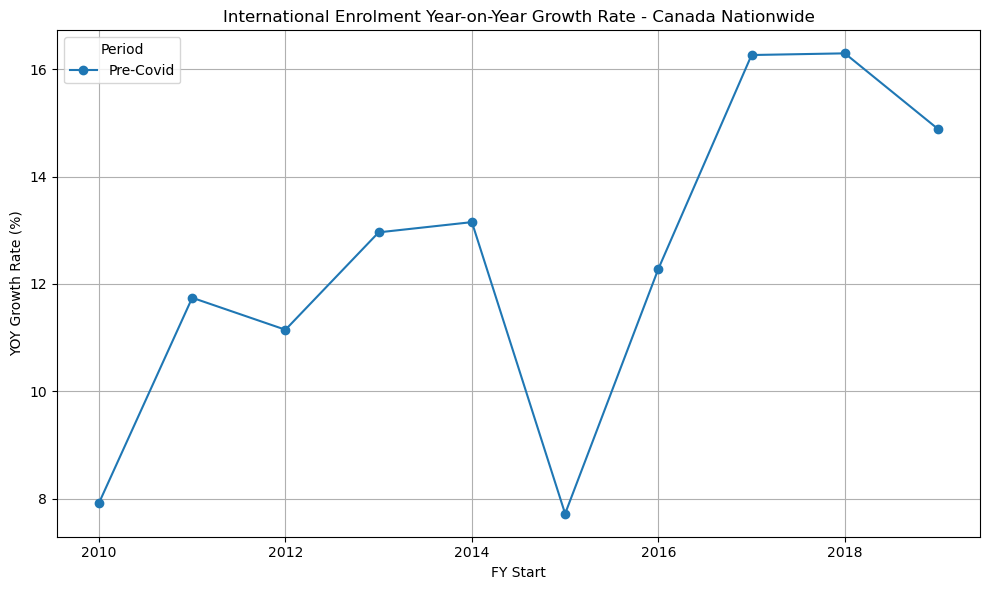

In [302]:
# plot year-on-year growth rates for the pre-covid and post-covid years
plt.figure(figsize=(10, 6))
plt.plot(pre_covid_canada_intl['FY Start'], pre_covid_canada_intl['YOY Growth'], marker='o', label='Pre-Covid')
plt.title('International Enrolment Year-on-Year Growth Rate - Canada Nationwide')
plt.xlabel('FY Start')
plt.ylabel('YOY Growth Rate (%)')
plt.legend(title='Period')
plt.grid(True)
plt.tight_layout()
plt.show()

In [303]:
post_covid_canada_intl

FY Start         Canadian Status  Enrolment Institution Name  \
11      2020  International students     329334   Canada (total)   
12      2021  International students     360162   Canada (total)   
13      2022  International students     421008   Canada (total)   

   Province/Territory  YOY Growth  
11             Canada         NaN  
12             Canada    9.360710  
13             Canada   16.894064

The YoY growth rate of international students barely went below 8% once in the ten year period and in all but two years was 11% or above. Year-on-year double digit growth for a decade.

### Provinces YoY Growth/Change

In [304]:
# Define function to compute YOY Growth for each province
def calculate_yoy_growth(df):
    # Sort by fiscal year to ensure correct calculations
    df = df.sort_values(by=['Province/Territory', 'FY Start']).copy()

    # Compute YOY Growth within each province
    df['YOY Growth'] = df.groupby('Province/Territory')['Enrolment'].pct_change() * 100

    # Optional: Fill NaN with 0 for first year entries
    df['YOY Growth'] = df['YOY Growth'].fillna(0)
    
    return df

# Apply function to both domestic and international enrolment datasets
provinces_df = calculate_yoy_growth(provinces_df)
provinces_df_intl = calculate_yoy_growth(provinces_df_intl)

In [305]:
# Function to create YOY Growth Rate plots for provinces
def plot_yoy_growth(df, title):
    fig = go.Figure()

    df_filtered = df[~df['Province/Territory'].isin(territories)] # Exclude territories

    # Loop through each province and add a trace
    for province in df_filtered['Province/Territory'].unique():
        province_data = df_filtered[df['Province/Territory'] == province]

        fig.add_trace(go.Scatter(
            x=province_data['FY Start'],
            y=province_data['YOY Growth'],
            mode='lines+markers',
            name=province,
            marker=dict(size=6),
            line=dict(width=2)
        ))

    # Add a horizontal line at 0% growth
    fig.add_shape(
        type="line",
        x0=df_filtered['FY Start'].min(),  # Start at the first year in the dataset
        x1=df_filtered['FY Start'].max(),  # End at the last year in the dataset
        y0=0, y1=0,  # 0% Growth Rate line
        line=dict(color="black", width=2, dash="dash")
    )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title="FY Start",
        yaxis_title="YOY Growth Rate (%)",
        legend_title="Provinces",
        legend=dict(
            orientation="h",  # Horizontal legend below graph
            x=0.5,
            y=-0.2,
            xanchor="center",
            yanchor="top"
        ),
        height=600,
        width=1000,
        margin=dict(l=50, r=50, t=50, b=100)
    )

    return fig

# Create interactive YOY growth plots for Domestic and International enrolment
domestic_growth_fig = plot_yoy_growth(provinces_df, "Year-on-Year Growth Rate (Domestic Students)")
international_growth_fig = plot_yoy_growth(provinces_df_intl, "Year-on-Year Growth Rate (International Students)")

# Show figures
domestic_growth_fig.show()
international_growth_fig.show()

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/942345976.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/942345976.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/942345976.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/942345976.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/942345976.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/942345976.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipy

Clearly from this we can see the similar behaviour around COVID that largely just affected international enrolment, with each province fairly quickly bouncing back after 2020. There is no real distinctive growth rate of a single province other than perhaps NB which dipped into negative growth in several years. 

PEI is represented by only two PSIs and only one is a university (UPEI) so it's more volatile numbers are because it is much less a provincial average than two institutions' decisions.

### Colleges vs Universities

First add the YoY growth column and then split the colleges from universities

In [306]:
# create YoY growth column for domestic and international enrolment
psi_dom['YOY Growth'] = psi_dom.groupby('Institution Name')['Enrolment'].pct_change() * 100
psi_intl['YOY Growth'] = psi_intl.groupby('Institution Name')['Enrolment'].pct_change() * 100

In [307]:
# Filter psi_intl for only College institutions - the word 'College' or 'CC' or 'CÉGEP' in their name
college_intl = psi_intl[psi_intl['Institution Name'].str.contains(r'College|CC|CÉGEP|Collège', regex=True)].fillna(0)
college_dom = psi_dom[psi_dom['Institution Name'].str.contains(r'College|CC|CÉGEP|Collège', regex=True)].fillna(0)

# trim further - remove records with ' U ' or 'U ' in the name
college_intl = college_intl[~college_intl['Institution Name'].str.contains(r'(^U of | U of )', regex=True)]

# filter for Universities - all names that do not appear in the college_intl dataframe
univ_intl = psi_intl[~psi_intl['Institution Name'].isin(college_intl['Institution Name'])].fillna(0)
univ_dom = psi_dom[~psi_dom['Institution Name'].isin(college_dom['Institution Name'])].fillna(0)

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/3238934448.py:6: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



**Retrospective comment:** As of Feb 10, individual PSIs on the graph with growth rates currently visualize poorly because there are one or two data points with very odd entries - usually where a change in data collection has led to 'international' being dramatically different one year and causing the subsequent YoY growth to appear as though it has crashed/exploded.

The aim of this section is to see if there is a meaningful difference between the enrolment change Year-on-Year between colleges and universities and we'll start that with an average instead, for a glance.

We will want to be careful with any outliers here which may skew the mean for a particular year

In [ ]:
# Function to create a box plot
def plot_yoy_growth_boxplot(df, title):
    fig = px.box(
        df, 
        x="FY Start", 
        y="YOY Growth",
        points="all",  # Show all outliers
        title=title
    )

    # Update layout
    fig.update_layout(
        xaxis_title="FY Start",
        yaxis_title="YOY Growth Rate (%)",
        height=500,
        width=800
    )

    # Show figure
    fig.show()

# Generate box plots for each dataset
plot_yoy_growth_boxplot(college_intl, "College International Enrolment YOY Growth")
plot_yoy_growth_boxplot(college_dom, "College Domestic Enrolment YOY Growth")
plot_yoy_growth_boxplot(univ_intl, "University International Enrolment YOY Growth")
plot_yoy_growth_boxplot(univ_dom, "University Domestic Enrolment YOY Growth")

There are going to be outliers in this data but the most egregious ones appear to be above 1000% so these data points can be replaced by the average of that year. It's noticeable that outliers for international growth rates are much higher than for domestic students. I suspect that is due to quirks in data collection one year and which category international students may have been reported in, upon changes the following year would make the number appear to be enormously different.

Below is some code to remove records where growth rates were over 1000% and institutions with less than 250 enrolment, likely the biggest sources of extreme outliers

In [ ]:
def clean_dataset_for_provincial_avg(df, enrolment_threshold=250, yoy_threshold=1000):
    """
    Excludes rows with Enrolment < 250 or YOY Growth > 1000.
    Infinity is treated as NaN, which gets excluded as well.
    """
    df = df.copy()

    # Replace infinity values with NaN
    df['YOY Growth'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Exclude rows with low enrolment or extreme YOY Growth
    df = df[
        (df['Enrolment'] >= enrolment_threshold) &
        (df['YOY Growth'] <= yoy_threshold) &
        (~df['YOY Growth'].isna())  # Exclude NaN
    ]

    return df

In [ ]:
def compute_provincial_avg(df):
    """
    Groups by Province/Territory and FY Start,
    computes average YOY Growth and count of records.
    """
    grouped = (
        df.groupby(['Province/Territory', 'FY Start'])['YOY Growth']
        .agg(['mean', 'count'])  # mean is average YOY, count is # of institutions
        .reset_index()
        .rename(columns={'mean': 'Avg_YOY_Growth', 'count': 'Num_Institutions'})
    )
    return grouped

In [311]:
def plot_provincial_growth(college_df, univ_df, provinces, title_prefix):
    """
    Creates one figure per province comparing average YOY Growth
    for Colleges vs. Universities (International or Domestic).
    """
    # Determine the max year for consistent X-axis
    max_year = max(college_df['FY Start'].max(), univ_df['FY Start'].max())

    for province in provinces:
        # Filter data
        college_data = college_df[college_df['Province/Territory'] == province]
        univ_data = univ_df[univ_df['Province/Territory'] == province]

        fig = go.Figure()

        # Colleges line
        fig.add_trace(go.Scatter(
            x=college_data['FY Start'],
            y=college_data['Avg_YOY_Growth'],
            mode='lines+markers',
            name='Colleges',
            text=college_data['Num_Institutions'],  # This will show # of institutions in hover
            hovertemplate=(
                'FY Start: %{x}<br>'
                'Avg Growth: %{y:.2f}%<br>'
                'Num Institutions: %{text}<extra></extra>'
            ),
            line=dict(color='blue', width=2)
        ))

        # Universities line
        fig.add_trace(go.Scatter(
            x=univ_data['FY Start'],
            y=univ_data['Avg_YOY_Growth'],
            mode='lines+markers',
            name='Universities',
            text=univ_data['Num_Institutions'],
            hovertemplate=(
                'FY Start: %{x}<br>'
                'Avg Growth: %{y:.2f}%<br>'
                'Num Institutions: %{text}<extra></extra>'
            ),
            line=dict(color='red', width=2)
        ))

        # Horizontal reference line at 0% growth
        fig.add_shape(
            type="line",
            x0=2009,
            x1=max_year,
            y0=0, y1=0,
            line=dict(color="black", width=2, dash="dash"),
            name="0% Growth Line"
        )

        fig.update_layout(
            title=f'{title_prefix} in {province}: Average YOY Growth',
            xaxis_title='FY Start',
            yaxis_title='Average YOY Growth (%)',
            legend_title='Institution Type',
            xaxis=dict(range=[2009, max_year]),
            height=600,
            width=1000
        )

        fig.show()

In [ ]:
# 1. Cleaning Data
# ---------------------------
college_intl_clean = clean_dataset_for_provincial_avg(college_intl, enrolment_threshold=250, yoy_threshold=1000)
univ_intl_clean = clean_dataset_for_provincial_avg(univ_intl, enrolment_threshold=250, yoy_threshold=1000)

# 2. Computing Provincial Averages
# ---------------------------
college_intl_avg = compute_provincial_avg(college_intl_clean)
univ_intl_avg = compute_provincial_avg(univ_intl_clean)

# Only keep desired provinces (e.g., BC, ON, AB) or derive from your data
provinces = ["British Columbia", "Ontario", "Alberta", "Quebec", "Manitoba", "Saskatchewan", "Nova Scotia", "New Brunswick", "Newfoundland and Labrador"]  

# 3. Plotting
# ---------------------------
plot_provincial_growth(
    college_df=college_intl_avg,
    univ_df=univ_intl_avg,
    provinces=provinces,
    title_prefix="International Students"
)


/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/1117058306.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [313]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Function to replace extreme outliers and infinity values
def replace_outliers_and_inf(df, threshold=1000, enrolment_threshold=500):
    df = df.copy()  # Avoid modifying the original dataframe

    # Remove infinity values and filter by enrolment > enrolment_threshold before computing yearly average
    df['YOY Growth'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Compute yearly average YOY Growth, excluding outliers and low-enrolment institutions
    yearly_avg = (
        df[(df['YOY Growth'] <= threshold) & (df['Enrolment'] > enrolment_threshold)]
        .groupby('FY Start')['YOY Growth']
        .mean()
    )

    # Replace outliers (> threshold) and infinity values with the yearly average
    df['YOY Growth'] = df.apply(
        lambda row: yearly_avg[row['FY Start']] if 
        (row['YOY Growth'] > threshold or pd.isna(row['YOY Growth'])) 
        else row['YOY Growth'], axis=1
    )

    return df

# Apply the function to all datasets
college_intl = replace_outliers_and_inf(college_intl)
college_dom = replace_outliers_and_inf(college_dom)
univ_intl = replace_outliers_and_inf(univ_intl)
univ_dom = replace_outliers_and_inf(univ_dom)


/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_5191/337608845.py:8: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
college_intl

FY Start         Canadian Status  Enrolment  \
42        2009  International students         42   
43        2010  International students         51   
44        2011  International students         48   
45        2012  International students         66   
46        2013  International students         60   
...        ...                     ...        ...   
3245      2016  International students          0   
3246      2020  International students          3   
3247      2021  International students          0   
3248      2022  International students          6   
3250      2014  International students          3   

                   Institution Name         Province/Territory  YOY Growth  
42    College of the North Atlantic  Newfoundland and Labrador    0.000000  
43    College of the North Atlantic  Newfoundland and Labrador   21.428571  
44    College of the North Atlantic  Newfoundland and Labrador   -5.882353  
45    College of the North Atlantic  Newfoundland and Labrador   37.500000  
46    College of the North Atlantic  Newfoundland and Labrador   -9.090909  
...                             ...                        ...         ...  
3245                 Aurora College      Northwest Territories -100.000000  
3246                 Aurora College      Northwest Territories   -0.142492  
3247                 Aurora College      Northwest Territories -100.000000  
3248                 Aurora College      Northwest Territories   37.583081  
3250         Nunavut Arctic College                    Nunavut    0.000000  

[1727 rows x 6 columns]

In [ ]:
# check for nulls in the college_intl dataframe
print(f"Nulls in 'YOY Growth': {college_intl['YOY Growth'].isnull().sum()}")

Nulls in 'YOY Growth': 0


In [ ]:
college_intl[college_intl['YOY Growth'] >= 500]

FY Start         Canadian Status  Enrolment  \
1142      2021  International students       1056   
1479      2018  International students         18   
1941      2012  International students        180   
2716      2011  International students         18   
2843      2014  International students         18   

                         Institution Name Province/Territory  YOY Growth  
1142                  CÉGEP de Sherbrooke             Quebec  802.564103  
1479  Collège Universel - Campus Gatineau             Quebec  500.000000  
1941                       Collège Boréal            Ontario  566.666667  
2716                     Lakeland College            Alberta  500.000000  
2843               Northern Lakes College            Alberta  500.000000

In [ ]:
college_intl[college_intl['Institution Name'] == 'Lakeland College']

FY Start         Canadian Status  Enrolment  Institution Name  \
2714      2009  International students          3  Lakeland College   
2715      2010  International students          3  Lakeland College   
2716      2011  International students         18  Lakeland College   
2717      2012  International students         21  Lakeland College   
2718      2013  International students         51  Lakeland College   
2719      2014  International students         48  Lakeland College   
2720      2015  International students         33  Lakeland College   
2721      2016  International students         69  Lakeland College   
2722      2017  International students        135  Lakeland College   
2723      2018  International students        264  Lakeland College   
2724      2019  International students        252  Lakeland College   
2725      2020  International students        174  Lakeland College   
2726      2021  International students        126  Lakeland College   
2727      2022  International students        141  Lakeland College   

     Province/Territory  YOY Growth  
2714            Alberta    0.000000  
2715            Alberta    0.000000  
2716            Alberta  500.000000  
2717            Alberta   16.666667  
2718            Alberta  142.857143  
2719            Alberta   -5.882353  
2720            Alberta  -31.250000  
2721            Alberta  109.090909  
2722            Alberta   95.652174  
2723            Alberta   95.555556  
2724            Alberta   -4.545455  
2725            Alberta  -30.952381  
2726            Alberta  -27.586207  
2727            Alberta   11.904762

In [ ]:
# Generate new box plots for each dataset
plot_yoy_growth_boxplot(college_intl, "College International Enrolment YOY Growth")
plot_yoy_growth_boxplot(college_dom, "College Domestic Enrolment YOY Growth")
plot_yoy_growth_boxplot(univ_intl, "University International Enrolment YOY Growth")
plot_yoy_growth_boxplot(univ_dom, "University Domestic Enrolment YOY Growth")

Now we can plot averages against colleges and universities for the years with more accuracy.

In [ ]:
import plotly.graph_objects as go

# Function to compute average YOY Growth while excluding small enrolments
def compute_avg_yoy(df):
    return (
        df[df['Enrolment'] >= 200]  # Exclude institutions with Enrolment < 200 to stop them skewing the averages too much
        .groupby('FY Start')['YOY Growth']
        .mean()
        .reset_index()
    )

# Compute averages with updated logic
college_intl_avg = compute_avg_yoy(college_intl)
college_dom_avg = compute_avg_yoy(college_dom)
univ_intl_avg = compute_avg_yoy(univ_intl)
univ_dom_avg = compute_avg_yoy(univ_dom)

# Create a Plotly figure
fig = go.Figure()

# Add College International line
fig.add_trace(go.Scatter(
    x=college_intl_avg['FY Start'],
    y=college_intl_avg['YOY Growth'],
    mode='lines+markers',
    name='College International',
    marker=dict(size=6),
    line=dict(width=2, color='blue', dash='solid')
))

# Add College Domestic line
fig.add_trace(go.Scatter(
    x=college_dom_avg['FY Start'],
    y=college_dom_avg['YOY Growth'],
    mode='lines+markers',
    name='College Domestic',
    marker=dict(size=6),
    line=dict(width=2, color='blue', dash='dash')
))

# Add University International line
fig.add_trace(go.Scatter(
    x=univ_intl_avg['FY Start'],
    y=univ_intl_avg['YOY Growth'],
    mode='lines+markers',
    name='University International',
    marker=dict(size=6),
    line=dict(width=2, color='red', dash='solid')
))

# Add University Domestic line
fig.add_trace(go.Scatter(
    x=univ_dom_avg['FY Start'],
    y=univ_dom_avg['YOY Growth'],
    mode='lines+markers',
    name='University Domestic',
    marker=dict(size=6),
    line=dict(width=2, color='red', dash='dash')
))

# Add a horizontal reference line at 0% YOY Growth
fig.add_shape(
    type="line",
    x0=min(college_intl_avg['FY Start'].min(), univ_intl_avg['FY Start'].min()),
    x1=max(college_intl_avg['FY Start'].max(), univ_intl_avg['FY Start'].max()),
    y0=0, y1=0,
    line=dict(color="black", width=2, dash="dash"),
    name="0% Growth Line"
)

# Update layout
fig.update_layout(
    title="Average YOY Growth Rate of Colleges & Universities (Domestic & International)",
    xaxis_title="FY Start",
    yaxis_title="Average YOY Growth Rate (%)",
    legend_title="Institution Type",
    height=600,
    width=1000,
    margin=dict(l=50, r=50, t=50, b=50)
)

# Show the figure
fig.show()


**Now it is easier to see the general behaviour**.

As with the higher-level data, international enrolment is driving virtually all enrolment growth in PSIs across Canada, but even removing the smallest institutions to avoid skew, the college data is significantly more volatile. Neither universities or colleges seem to have any years of single digit international growth except for Universities in 2021, recovering from the pandemic.

The recovery from Covid was much more rapid for Colleges, the growth years were twice (or more) as strong, and the 'down years' were much more significantly down than in universities.

There isn't much to tell apart from the domestic enrolment data, other than they have stayed more or less equivalent. There may be something in the noticeable growth for 2013 for both categories if it is largely a product of first-year undergraduate programs having larger enrolment (is there census-level data indicating more births in 1995 than 1994 or 1993 --> more 18 year olds in 2013 than 2012 or 2011?)

In [ ]:
# number of records in each dataframe
print(f"College International: {college_intl[college_intl['Enrolment'] > 200].shape[0]} records")
print(f"College Domestic: {college_dom[college_dom['Enrolment'] > 200].shape[0]} records")
print(f"University International: {univ_intl[univ_intl['Enrolment'] > 200].shape[0]} records")
print(f"University Domestic: {univ_dom[univ_dom['Enrolment'] > 200].shape[0]} records")

College International: 530 records
College Domestic: 1717 records
University International: 955 records
University Domestic: 1315 records


Below we will plot the average international student growth rates for the major provinces - the smaller ones do not have enough institutions above 250 enrolment for a meaningful average.

In [ ]:
# List of provinces to include (British Columbia, Ontario, Alberta)
selected_provinces = ["British Columbia", "Ontario", "Alberta"]

# Function to compute average YOY Growth per province (excluding low enrolments)
def compute_avg_yoy_by_province(df, enrolment_threshold=250):
    return (
        df[df['Enrolment'] >= enrolment_threshold]  # Filter institutions with Enrolment < 250
        .groupby(['Province/Territory', 'FY Start'])['YOY Growth']
        .mean()
        .reset_index()
    )

# Compute province-level averages for Colleges & Universities (International Students)
college_intl_province_avg = compute_avg_yoy_by_province(college_intl)
univ_intl_province_avg = compute_avg_yoy_by_province(univ_intl)

# Determine the max FY Start to set the correct X-axis range
max_year = max(college_intl_province_avg['FY Start'].max(), univ_intl_province_avg['FY Start'].max())

# Iterate over selected provinces to create a separate line plot
for province in selected_provinces:
    # Filter data for the current province
    college_data = college_intl_province_avg[college_intl_province_avg['Province/Territory'] == province]
    univ_data = univ_intl_province_avg[univ_intl_province_avg['Province/Territory'] == province]

    # Create a Plotly figure
    fig = go.Figure()

    # Add Colleges (International)
    fig.add_trace(go.Scatter(
        x=college_data['FY Start'],
        y=college_data['YOY Growth'],
        mode='lines+markers',
        name="Colleges (Int'l Students)",
        marker=dict(size=6),
        line=dict(width=2, color="blue", dash="solid")
    ))

    # Add Universities (International)
    fig.add_trace(go.Scatter(
        x=univ_data['FY Start'],
        y=univ_data['YOY Growth'],
        mode='lines+markers',
        name="Universities (Int'l Students)",
        marker=dict(size=6),
        line=dict(width=2, color="red", dash="solid")
    ))

    # Add a horizontal reference line at 0% YOY Growth
    fig.add_shape(
        type="line",
        x0=2009,
        x1=max_year,
        y0=0, y1=0,
        line=dict(color="black", width=2, dash="dash"),
        name="0% Growth Line"
    )

    # Update layout with fixed X-axis range
    fig.update_layout(
        title=f'Average YOY Growth of International Students in {province} (Colleges vs. Universities)',
        xaxis_title="FY Start",
        yaxis_title="Average YOY Growth Rate (%)",
        legend_title="Institution Type",
        xaxis=dict(range=[2009, max_year]),  # Set X-axis range to start at 2009
        height=600,
        width=1000,
        margin=dict(l=50, r=50, t=50, b=50)
    )

    # Show the figure
    fig.show()

Side note: (For some unknown reason the Saskatchewan plot is not displaying properly)

Because of the limited number of institutions above the international enrolment figure in some smaller provinces skewing the averags, this above visual is probably only relevant to the major provinces ON, BC and AB - we are still seeing the college growth is more volatile than the universities.

### Re-plot individual schools without the outlier data:

We've cleaned some of the most egregious growth rate values out now, let's try to plot individual schools

In [ ]:
# List of territories to exclude
territories = ["Nunavut", "Northwest Territories", "Yukon"]

# Define institution types and their datasets
institution_types = {
    "Colleges": {"intl students": college_intl, "domestic": college_dom},
    "Universities": {"intl students": univ_intl, "domestic": univ_dom}
}

# Iterate over each institution type (Colleges & Universities)
for inst_type, datasets in institution_types.items():
    for dataset_name, df in datasets.items():
        
        # Get unique provinces (excluding territories)
        unique_provinces = sorted(df['Province/Territory'].unique())
        unique_provinces = [p for p in unique_provinces if p not in territories]

        # Iterate over each province to create a separate line plot
        for province in unique_provinces:
            # Filter the data for the current province
            province_data = df[df['Province/Territory'] == province]

            # Create a Plotly figure for the province
            fig = go.Figure()

            # Add lines for each institution
            for school in province_data['Institution Name'].unique():
                school_data = province_data[province_data['Institution Name'] == school]
                fig.add_trace(go.Scatter(
                    x=school_data['FY Start'],
                    y=school_data['YOY Growth'],
                    mode='lines+markers',
                    name=school,  # Institution name in legend
                    marker=dict(size=6),
                    line=dict(width=2)
                ))

            # Add a horizontal reference line at 0% YOY Growth
            fig.add_shape(
                type="line",
                x0=province_data['FY Start'].min(),
                x1=province_data['FY Start'].max(),
                y0=0, y1=0,
                line=dict(color="black", width=2, dash="dash"),
                name="0% Growth Line"
            )

            # Update layout
            fig.update_layout(
                title=f'YOY Growth Rate of {inst_type} ({dataset_name.capitalize()}) in {province}',
                xaxis_title="FY Start",
                yaxis_title="YOY Growth Rate (%)",
                legend_title="Institutions",
                legend=dict(
                    orientation="v",  # Vertical legend
                    x=1.05,  # Move legend outside the plot
                    y=1
                ),
                height=600,
                width=1300,
                margin=dict(l=50, r=200, t=50, b=50)  # Adjust right margin for legend
            )

            # Show the figure
            fig.show()

Sadly it's quite difficult to take anything from these because the growth rates get massively skewed by some poor data which we may need to go back and rectify.

In [ ]:
import plotly.graph_objects as go

# List of territories to exclude
territories = ["Nunavut", "Northwest Territories", "Yukon"]

# Get unique provinces (excluding territories)
unique_provinces = sorted(univ_intl['Province/Territory'].unique())
unique_provinces = [p for p in unique_provinces if p not in territories]

# Iterate over each province to create a separate line plot
for province in unique_provinces:
    # Filter the data for the current province
    province_data = univ_intl[univ_intl['Province/Territory'] == province]

    # Create a Plotly figure for the province
    fig = go.Figure()

    # Add lines for each university
    for school in province_data['Institution Name'].unique():
        school_data = province_data[province_data['Institution Name'] == school]
        fig.add_trace(go.Scatter(
            x=school_data['FY Start'],
            y=school_data['YOY Growth'],
            mode='lines+markers',
            name=school,  # Institution name in legend
            marker=dict(size=6),
            line=dict(width=2)
        ))

    # Add a horizontal reference line at 0% YOY Growth
    fig.add_shape(
        type="line",
        x0=province_data['FY Start'].min(),
        x1=province_data['FY Start'].max(),
        y0=0, y1=0,
        line=dict(color="black", width=2, dash="dash"),
        name="0% Growth Line"
    )

    # Update layout
    fig.update_layout(
        title=f'YOY Growth Rate of International Students at Universities in {province}',
        xaxis_title="FY Start",
        yaxis_title="YOY Growth Rate (%)",
        legend_title="Universities",
        legend=dict(
            orientation="v",  # Vertical legend
            x=1.05,  # Move legend outside the plot
            y=1
        ),
        height=600,
        width=1300,
        margin=dict(l=50, r=200, t=50, b=50)  # Adjust right margin for legend
    )

    # Show the figure
    fig.show()


## Visualising International Enrolment across Provinces & Schools 2009/10 - 2022/23

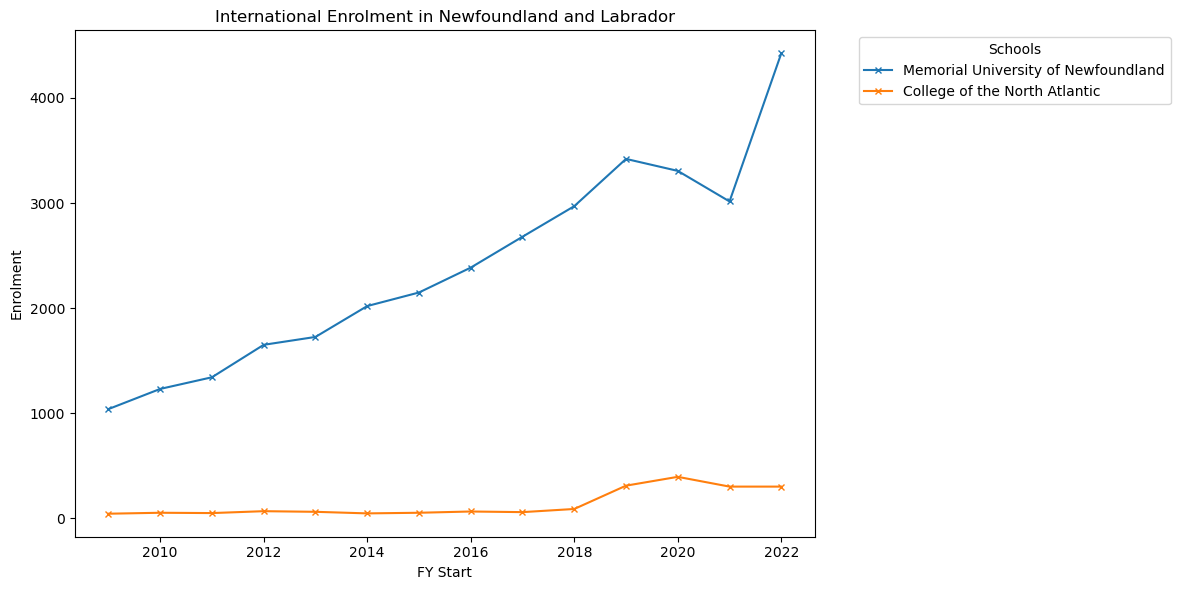

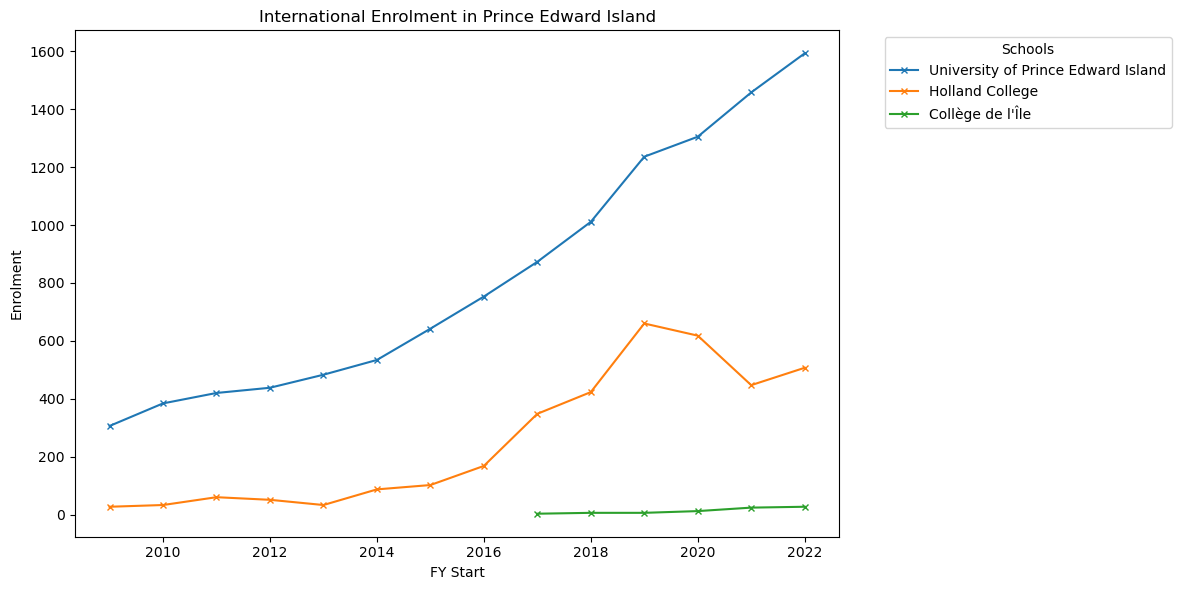

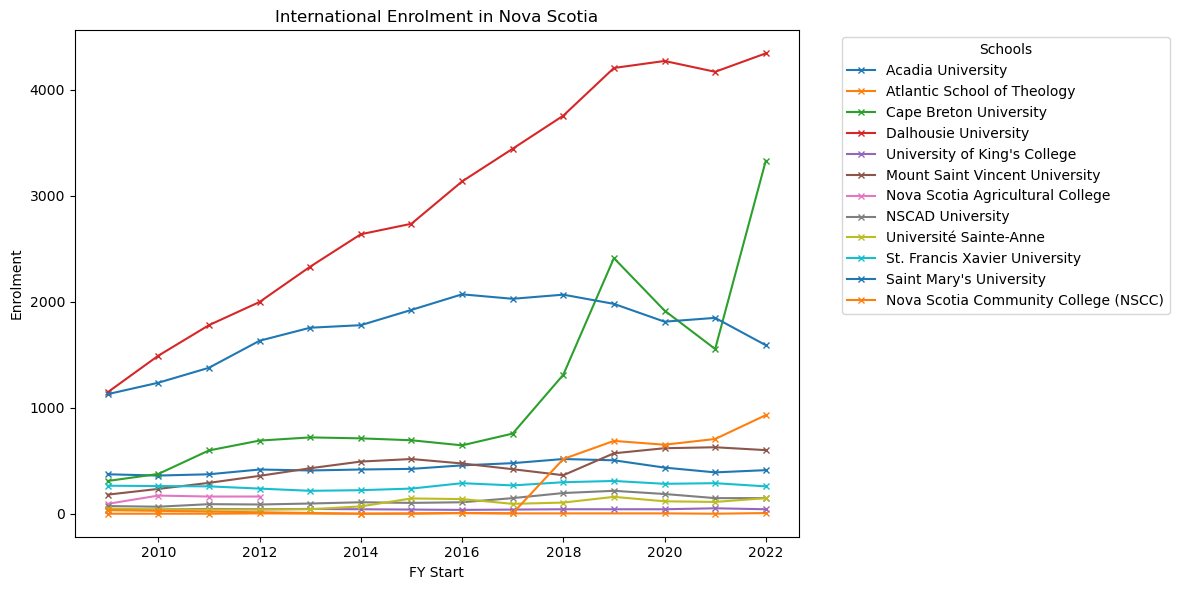

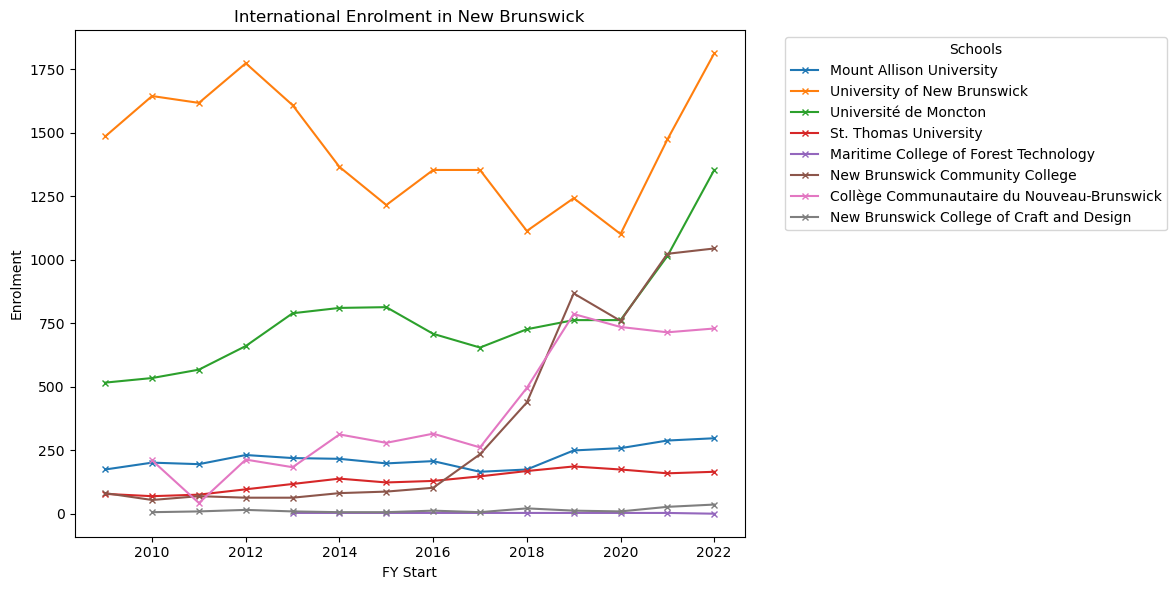

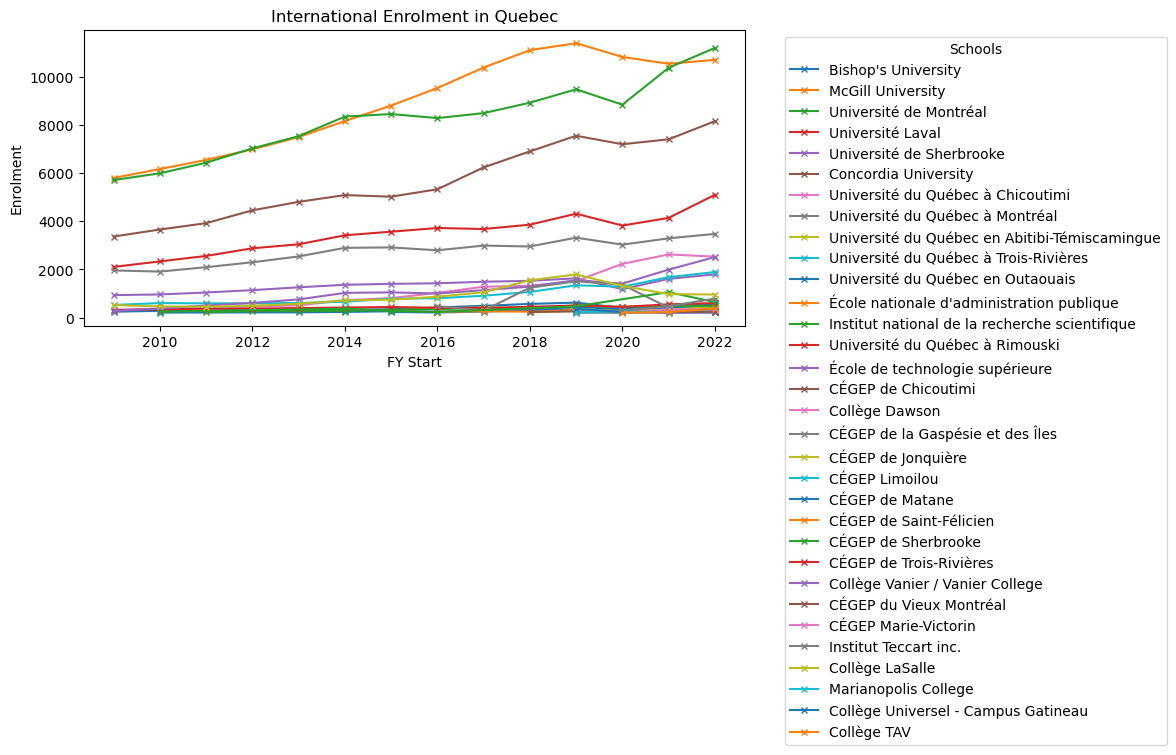

/var/folders/jj/bww8jnqd2lg73nm4k1z5kbmc0000gn/T/ipykernel_53874/1225446732.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


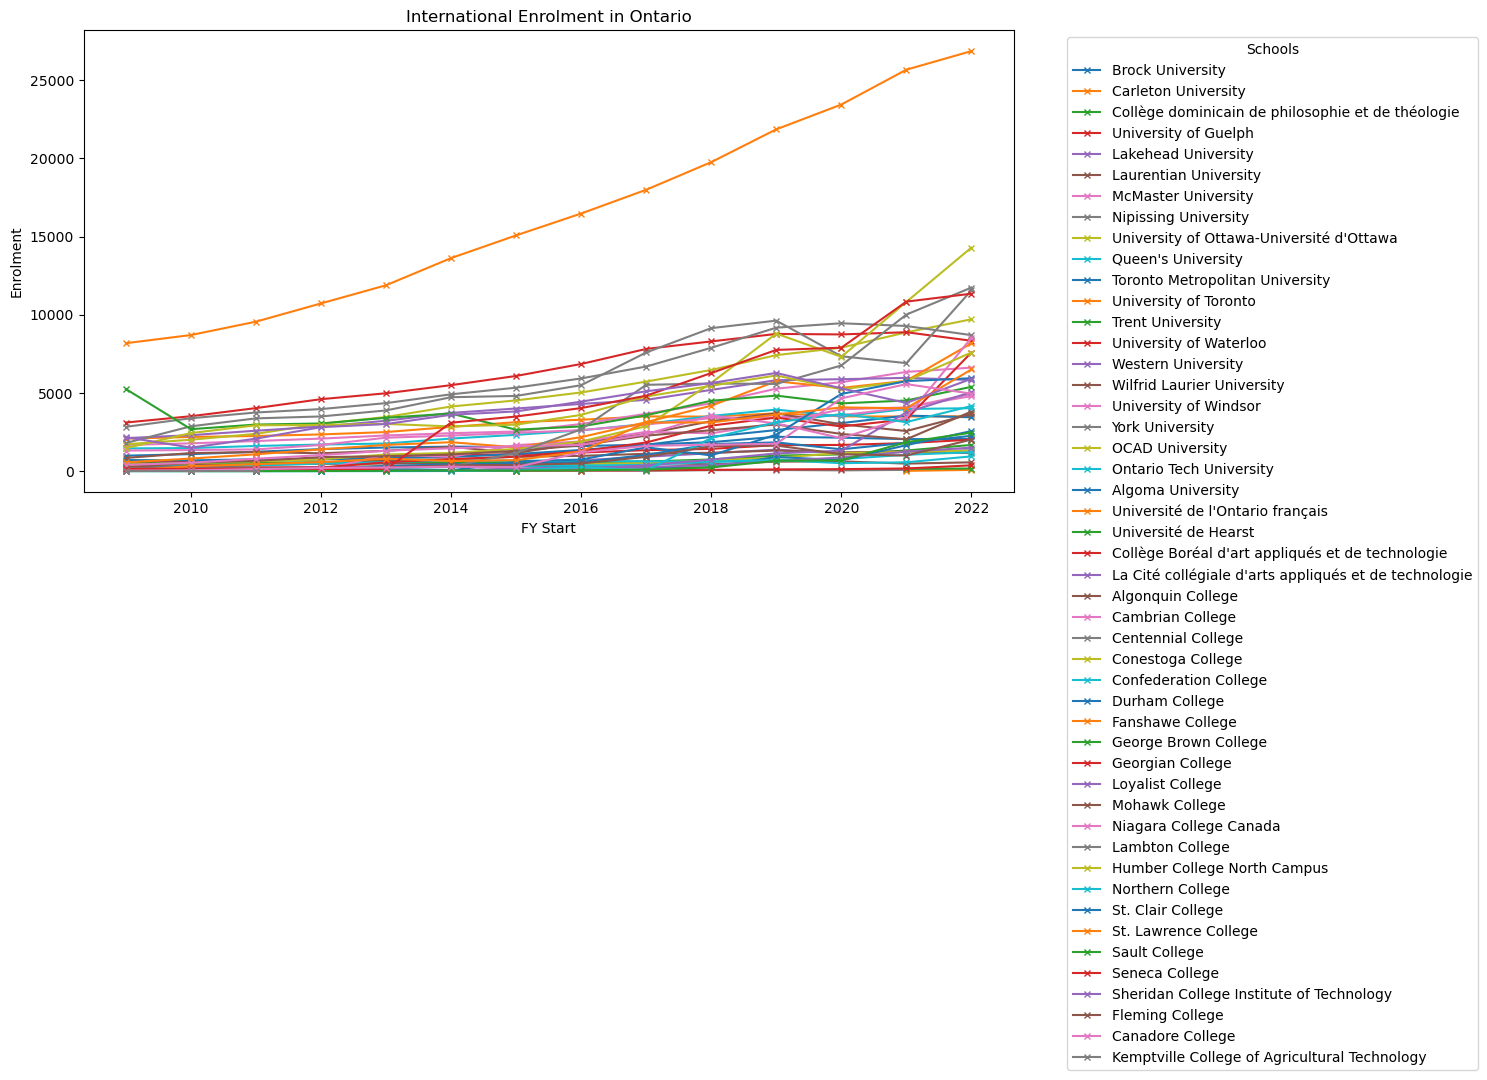

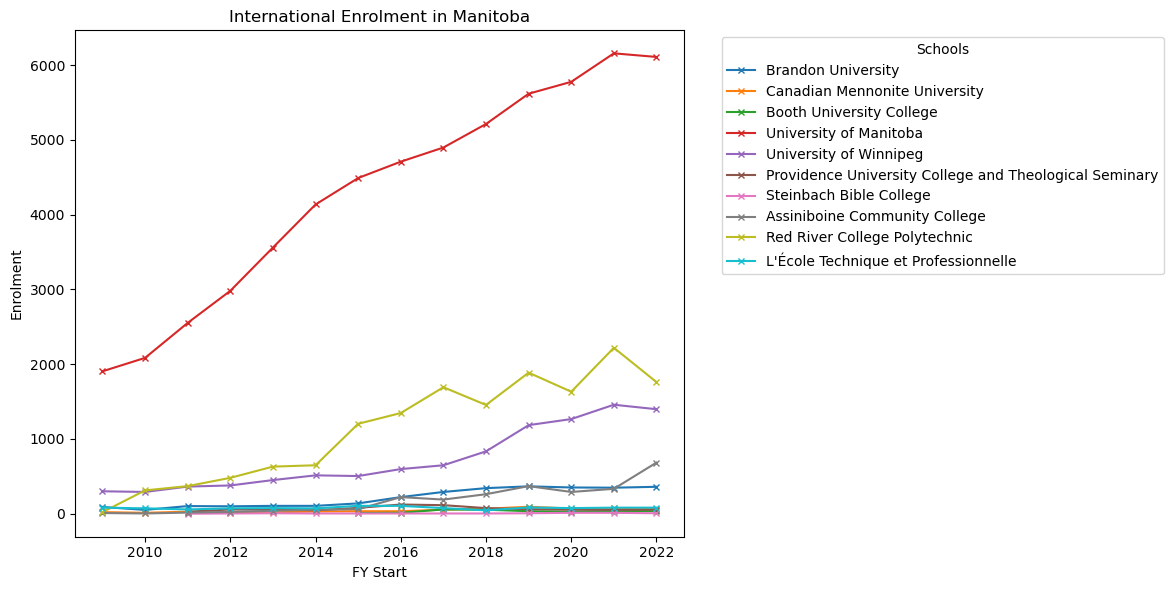

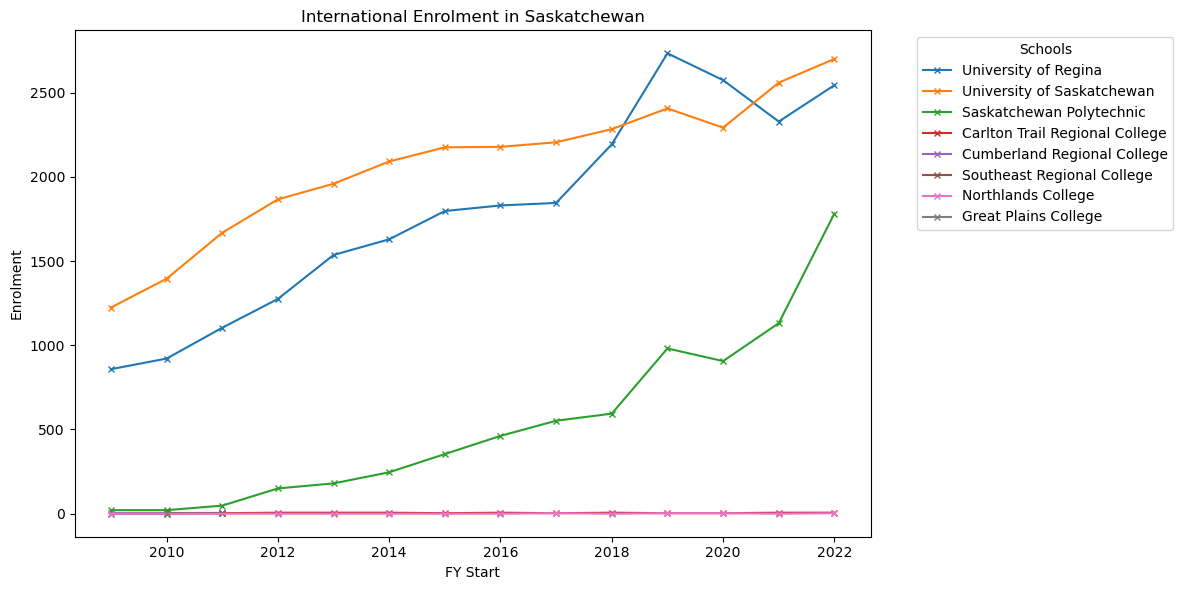

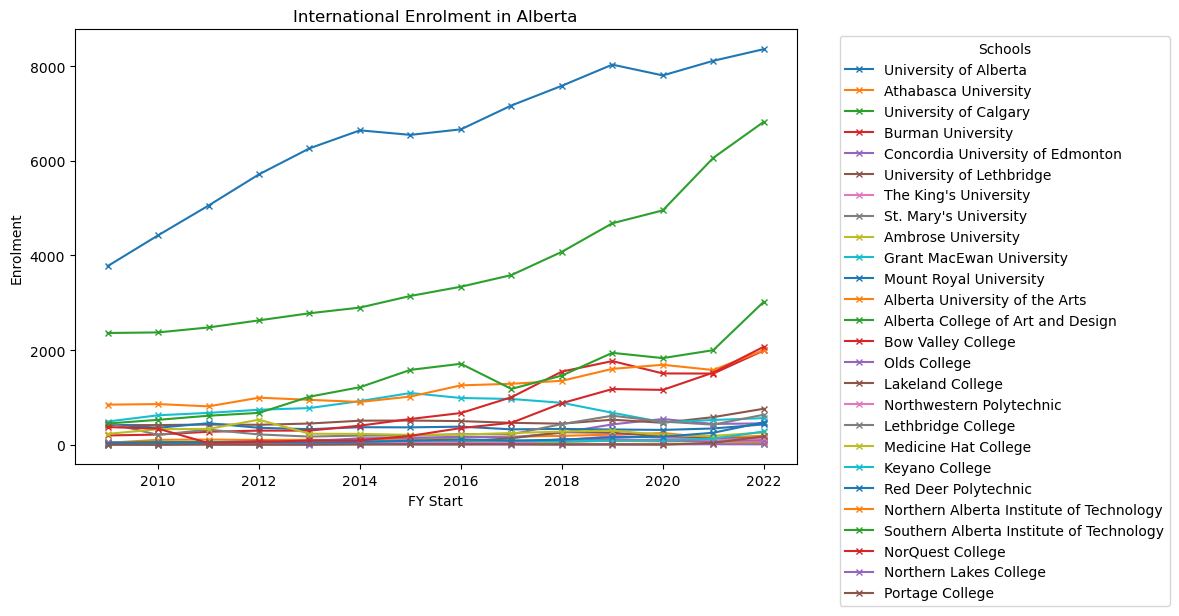

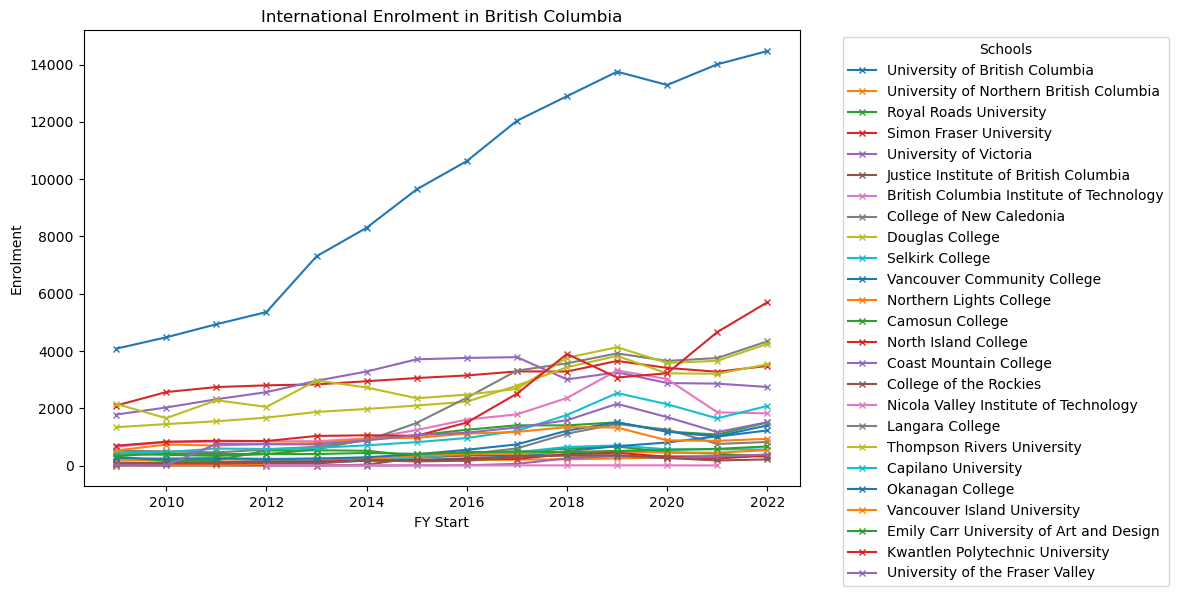

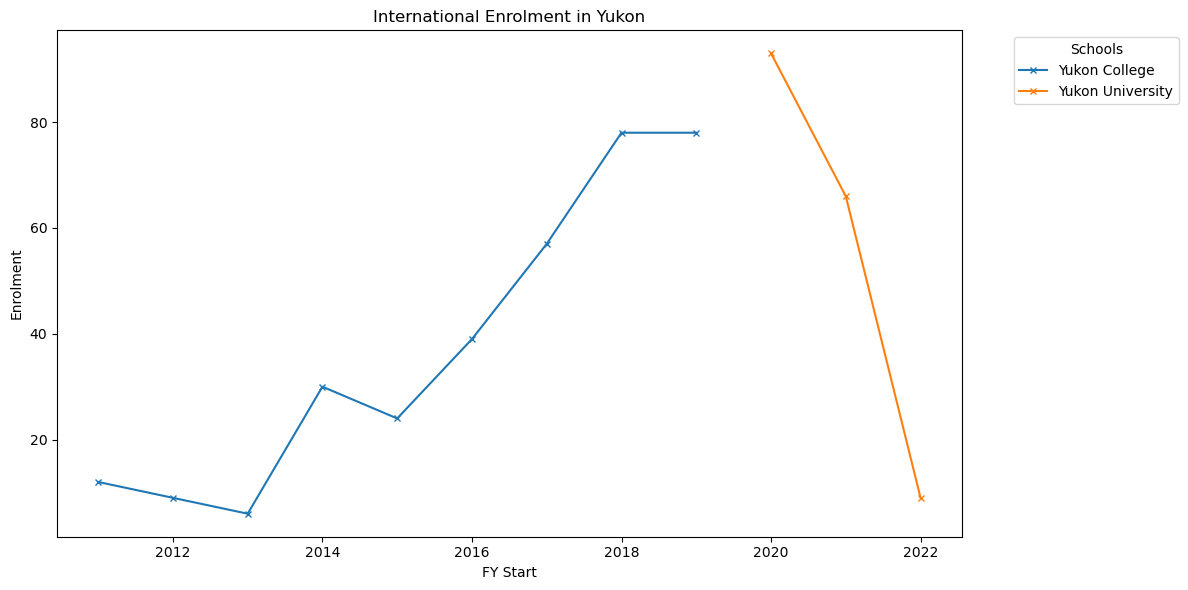

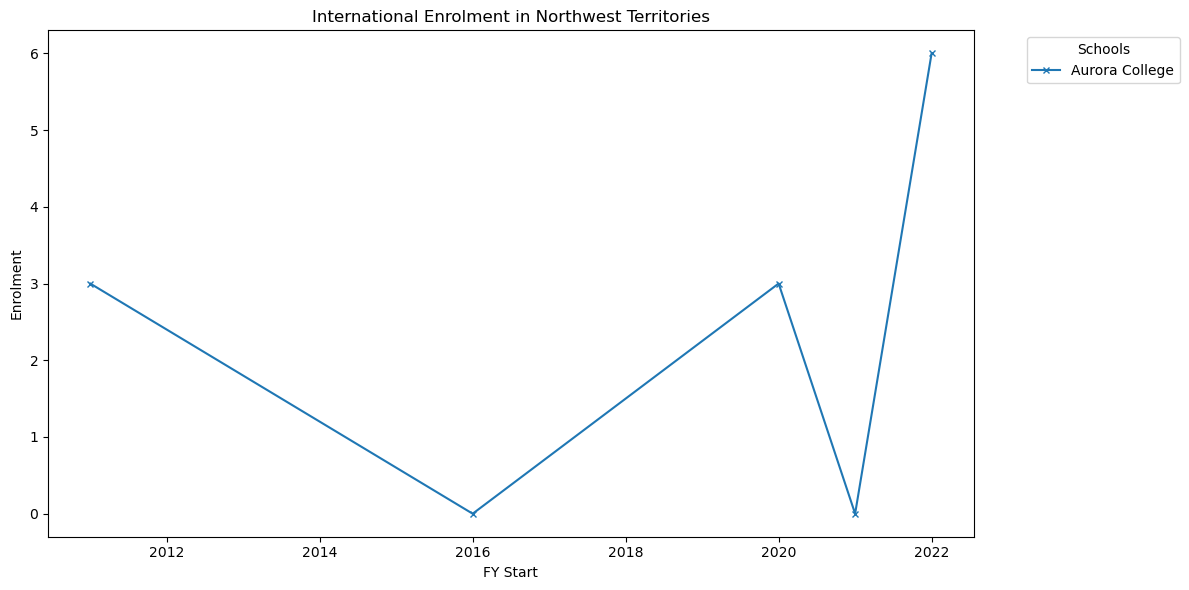

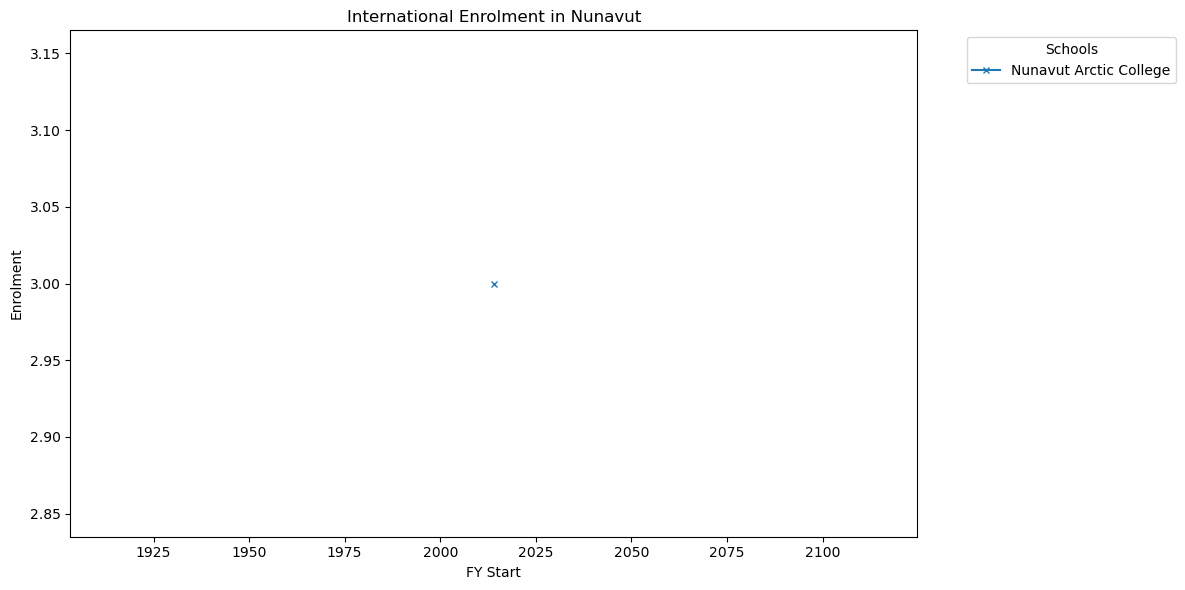

In [ ]:
# Get the unique provinces/territories from the dataframe
unique_provinces_territories = colleges_universities_df_intl['Province/Territory'].unique()

# Iterate over each province/territory to create separate graphs
for province in unique_provinces_territories:
    # Filter the data for the current province/territory
    province_data = colleges_universities_df_intl[colleges_universities_df_intl['Province/Territory'] == province]

    # Apply the condition for Quebec - there are a LOT of tiny CEGEPs that make the display tough to read
    if province == "Quebec":
        province_data = province_data[province_data['Enrolment'] >= 200]

    # Create a new figure for the province
    plt.figure(figsize=(12, 6))

    # Plot enrolment trends for each school in the current province/territory
    for school in province_data['School Name'].unique():
        school_data = province_data[province_data['School Name'] == school]
        plt.plot(
            school_data['FY Start'],
            school_data['Enrolment'],
            label=school,
            marker='x',
            markersize=4
        )

    # Set the title and labels
    plt.title(f'International Enrolment in {province}')
    plt.xlabel('FY Start')
    plt.ylabel('Enrolment')

    # Display legend and layout
    plt.legend(title='Schools', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

With the last three figures, we can see that compared to the provinces, the territories are incredibly small numbers and it's doubtful they have any contribution to international student trends seen in the provinces. They are two or three orders of magnitude smaller than everybody else.

For that reason we will **leave the territories out of the analysis** from here on.

## Combining Domestic and International enrolment in each province

### Pivot the tables so that every row is one institution in one year, with international and domestic enrolment, which we will then combine in one dataframe

In [ ]:
colleges_universities_df.head()

FY Start Registration status             Status  Enrolment  \
28      2009   Full-time student  Canadian students      14298   
29      2010   Full-time student  Canadian students      14196   
30      2011   Full-time student  Canadian students      14097   
31      2012   Full-time student  Canadian students      13923   
32      2013   Full-time student  Canadian students      13611   

                            School Name         Province/Territory  
28  Memorial University of Newfoundland  Newfoundland and Labrador  
29  Memorial University of Newfoundland  Newfoundland and Labrador  
30  Memorial University of Newfoundland  Newfoundland and Labrador  
31  Memorial University of Newfoundland  Newfoundland and Labrador  
32  Memorial University of Newfoundland  Newfoundland and Labrador

In [ ]:
colleges_universities_df_intl.head()

FY Start Registration status                  Status  Enrolment  \
28      2009   Full-time student  International students       1038   
29      2010   Full-time student  International students       1230   
30      2011   Full-time student  International students       1341   
31      2012   Full-time student  International students       1650   
32      2013   Full-time student  International students       1725   

                            School Name         Province/Territory  
28  Memorial University of Newfoundland  Newfoundland and Labrador  
29  Memorial University of Newfoundland  Newfoundland and Labrador  
30  Memorial University of Newfoundland  Newfoundland and Labrador  
31  Memorial University of Newfoundland  Newfoundland and Labrador  
32  Memorial University of Newfoundland  Newfoundland and Labrador

Because of the very small numbers involved, I will ignore the territories of Nunavut, Yukon and Northwest Territory

In [ ]:
# List of territories to exclude
territories = ["Yukon", "Northwest Territories", "Nunavut"]

# Step 1: Filter out territories from colleges_universities_df and include 'Province/Territory' in the index
domestic_df = colleges_universities_df[
    (colleges_universities_df['Status'] == 'Canadian students') &
    (~colleges_universities_df['Province/Territory'].isin(territories))
].pivot_table(
    index=['School Name', 'Province/Territory', 'FY Start'],
    values='Enrolment',
    aggfunc='sum'
).reset_index()

# Rename the 'Enrolment' column to 'Domestic Enrolment'
domestic_df.rename(columns={'Enrolment': 'Domestic Enrolment'}, inplace=True)

# Step 2: Filter out territories from colleges_universities_df_intl and include 'Province/Territory' in the index
international_df = colleges_universities_df_intl[
    (colleges_universities_df_intl['Status'] == 'International students') &
    (~colleges_universities_df_intl['Province/Territory'].isin(territories))
].pivot_table(
    index=['School Name', 'Province/Territory', 'FY Start'],
    values='Enrolment',
    aggfunc='sum'
).reset_index()

# Rename the 'Enrolment' column to 'International Enrolment'
international_df.rename(columns={'Enrolment': 'International Enrolment'}, inplace=True)

# Step 3: Join the two DataFrames on 'School Name', 'Province/Territory', and 'FY Start'
combined_df = pd.merge(
    domestic_df,
    international_df,
    on=['School Name', 'Province/Territory', 'FY Start'],
    how='outer'
)

# Fill any NaN values with 0, as some institutions might not have data for both domestic and international enrolments
combined_df.fillna(0, inplace=True)

# Display the combined DataFrame
print(combined_df)


                    School Name Province/Territory  FY Start  \
0             Acadia University        Nova Scotia      2009   
1             Acadia University        Nova Scotia      2010   
2             Acadia University        Nova Scotia      2011   
3             Acadia University        Nova Scotia      2012   
4             Acadia University        Nova Scotia      2013   
...                         ...                ...       ...   
3246  École nationale de Cirque             Quebec      2018   
3247  École nationale de Cirque             Quebec      2019   
3248  École nationale de Cirque             Quebec      2020   
3249  École nationale de Cirque             Quebec      2021   
3250  École nationale de Cirque             Quebec      2022   

      Domestic Enrolment  International Enrolment  
0                 2667.0                    372.0  
1                 2727.0                    360.0  
2                 2976.0                    372.0  
3                 3135.

In [ ]:
combined_df

School Name Province/Territory  FY Start  \
0             Acadia University        Nova Scotia      2009   
1             Acadia University        Nova Scotia      2010   
2             Acadia University        Nova Scotia      2011   
3             Acadia University        Nova Scotia      2012   
4             Acadia University        Nova Scotia      2013   
...                         ...                ...       ...   
3246  École nationale de Cirque             Quebec      2018   
3247  École nationale de Cirque             Quebec      2019   
3248  École nationale de Cirque             Quebec      2020   
3249  École nationale de Cirque             Quebec      2021   
3250  École nationale de Cirque             Quebec      2022   

      Domestic Enrolment  International Enrolment  
0                 2667.0                    372.0  
1                 2727.0                    360.0  
2                 2976.0                    372.0  
3                 3135.0                    417.0  
4                 3288.0                    408.0  
...                  ...                      ...  
3246                42.0                     54.0  
3247                69.0                     60.0  
3248                63.0                     51.0  
3249                45.0                     54.0  
3250                42.0                     60.0  

[3251 rows x 5 columns]

Add the Francophone tag - 1 represents that the main language of instruction is French.

In [ ]:
# List of strings that indicate the school is Francophone
francophone_schools = [
    "Université Sainte-Anne", "Collège Boréal", "Collège d'Alfred", 
    "Collège dominicain", "La Cité collégiale", "Université de Hearst", 
    "Université de l'Ontario français", "Université de Moncton", 
    "Collège Communautaire du Nouveau-Brunswick", "Collège de l'Île", "L'École Technique et Professionnelle"
]

# Create the "Francophone" column with 0 as the default value
combined_df['Francophone'] = 0

# Update the "Francophone" column based on the School Name
combined_df['Francophone'] = combined_df.apply(
    lambda row: 1 if (
        any(francophone in row['School Name'] for francophone in francophone_schools) or 
        (row['Province/Territory'] == "Quebec" and "McGill University" not in row['School Name'])
    ) else 0,
    axis=1
)

# Display the updated DataFrame
print(combined_df[['School Name', 'Province/Territory', 'Francophone']].head())


         School Name Province/Territory  Francophone
0  Acadia University        Nova Scotia            0
1  Acadia University        Nova Scotia            0
2  Acadia University        Nova Scotia            0
3  Acadia University        Nova Scotia            0
4  Acadia University        Nova Scotia            0


We now have every institution in every FY from 2011- to 2021- with their domestic and international enrolment side by side

In [ ]:
# create a domestic/international ratio column
combined_df['% International'] = round((combined_df['International Enrolment'] / (combined_df['Domestic Enrolment'] + combined_df['International Enrolment'])) * 100, 2)

In [ ]:
combined_df['% International'].sort_values(ascending=False)

129     100.00
1777     86.74
1776     84.70
3028     84.38
2126     81.39
         ...  
128       0.00
2045      0.00
2044      0.00
2043      0.00
736       0.00
Name: % International, Length: 3251, dtype: float64

To plot the provincial behaviour as a total and an average, we will create 2 new record rows for every province and every FY. One that average the figures for every province in every year and one that sums them up.

We will also need to do this to distinguish Francophone schools from others in the eastern provinces like ON, NB, PEI and NS. We have assumed all of QC, except McGill University is primarily Francophone

In [ ]:
import pandas as pd

# Mapping of full province names to their codes - easier to read
province_codes = {
    "British Columbia": "BC",
    "Alberta": "AB",
    "Ontario": "ON",
    "Prince Edward Island": "PEI",
    "New Brunswick": "NB",
    "Nova Scotia": "NS",
    "Saskatchewan": "SK",
    "Manitoba": "MB",
    "Quebec": "QC",
    "Newfoundland and Labrador": "NL"
}

# Make a copy of the existing combined_df to add new records
new_records = []

# Get unique provinces and fiscal years - all ten provinces from 2011 to 2021
provinces = combined_df['Province/Territory'].unique()
fiscal_years = combined_df['FY Start'].unique()

# Iterate over each province and fiscal year to calculate totals and averages for Francophone and English PSIs
for province in provinces:
    for fy in fiscal_years:
        # Filter the data for the current province and fiscal year
        province_data = combined_df[
            (combined_df['Province/Territory'] == province) & (combined_df['FY Start'] == fy)
        ]

        # Split the data into Francophone and non-Francophone
        fr_data = province_data[province_data['Francophone'] == 1]
        en_data = province_data[province_data['Francophone'] == 0]

        # Calculate total and average values for English institutions
        en_domestic_total = en_data['Domestic Enrolment'].sum()
        en_intl_total = en_data['International Enrolment'].sum()
        en_intl_pct_total = (en_intl_total / (en_intl_total + en_domestic_total) * 100) if (en_intl_total + en_domestic_total) > 0 else 0

        # Only proceed with Francophone statistics if there are Francophone institutions in the data
        if not fr_data.empty:
            # Calculate total values for Francophone institutions
            fr_domestic_total = fr_data['Domestic Enrolment'].sum()
            fr_intl_total = fr_data['International Enrolment'].sum()
            fr_intl_pct_total = (fr_intl_total / (fr_intl_total + fr_domestic_total) * 100) if (fr_intl_total + fr_domestic_total) > 0 else 0

            # Get province code
            province_code = province_codes.get(province, province)  # Default to full name if not found

            # Create School Name entries using province codes for Francophone
            fr_total = f"{province_code} FR Total"

            # Append Francophone total record
            new_records.append({
                'School Name': fr_total,
                'Province/Territory': province,
                'FY Start': fy,
                'Domestic Enrolment': fr_domestic_total,
                'International Enrolment': fr_intl_total,
                '% International': fr_intl_pct_total,
                'Francophone': 1  # Tag as Francophone
            })

        # Get the province code from the dictionary
        province_code = province_codes.get(province, province)  # Default to full name if not found

        # Create School Name entries for the provinces using province codes for English
        en_total = f"{province_code} Total"

        # Append English total record
        new_records.append({
            'School Name': en_total,
            'Province/Territory': province,
            'FY Start': fy,
            'Domestic Enrolment': en_domestic_total,
            'International Enrolment': en_intl_total,
            '% International': en_intl_pct_total,
            'Francophone': 0  # Tag as non-Francophone
        })

# Convert new records to a DataFrame
new_records_df = pd.DataFrame(new_records)

# Append the new records to the original DataFrame
combined_df = pd.concat([combined_df, new_records_df], ignore_index=True)

# Display the updated DataFrame
print(combined_df)

            School Name    Province/Territory  FY Start  Domestic Enrolment  \
0     Acadia University           Nova Scotia      2009              2667.0   
1     Acadia University           Nova Scotia      2010              2727.0   
2     Acadia University           Nova Scotia      2011              2976.0   
3     Acadia University           Nova Scotia      2012              3135.0   
4     Acadia University           Nova Scotia      2013              3288.0   
...                 ...                   ...       ...                 ...   
3462          PEI Total  Prince Edward Island      2020              4881.0   
3463       PEI FR Total  Prince Edward Island      2021                 6.0   
3464          PEI Total  Prince Edward Island      2021              5022.0   
3465       PEI FR Total  Prince Edward Island      2022                 9.0   
3466          PEI Total  Prince Edward Island      2022              4983.0   

      International Enrolment  Francophone  % Inter

In [ ]:
combined_df

School Name    Province/Territory  FY Start  Domestic Enrolment  \
0     Acadia University           Nova Scotia      2009              2667.0   
1     Acadia University           Nova Scotia      2010              2727.0   
2     Acadia University           Nova Scotia      2011              2976.0   
3     Acadia University           Nova Scotia      2012              3135.0   
4     Acadia University           Nova Scotia      2013              3288.0   
...                 ...                   ...       ...                 ...   
3462          PEI Total  Prince Edward Island      2020              4881.0   
3463       PEI FR Total  Prince Edward Island      2021                 6.0   
3464          PEI Total  Prince Edward Island      2021              5022.0   
3465       PEI FR Total  Prince Edward Island      2022                 9.0   
3466          PEI Total  Prince Edward Island      2022              4983.0   

      International Enrolment  Francophone  % International  
0                       372.0            0        12.240000  
1                       360.0            0        11.660000  
2                       372.0            0        11.110000  
3                       417.0            0        11.740000  
4                       408.0            0        11.040000  
...                       ...          ...              ...  
3462                   1923.0            0        28.262787  
3463                     24.0            1        80.000000  
3464                   1905.0            0        27.501083  
3465                     27.0            1        75.000000  
3466                   2100.0            0        29.648454  

[3467 rows x 7 columns]

In [ ]:
combined_df[combined_df['Province/Territory'] == 'Alberta']

School Name Province/Territory  FY Start  \
14    Alberta College of Art and Design            Alberta      2009   
15    Alberta College of Art and Design            Alberta      2010   
16    Alberta College of Art and Design            Alberta      2011   
17    Alberta College of Art and Design            Alberta      2012   
18    Alberta College of Art and Design            Alberta      2013   
...                                 ...                ...       ...   
3288                           AB Total            Alberta      2018   
3289                           AB Total            Alberta      2019   
3290                           AB Total            Alberta      2020   
3291                           AB Total            Alberta      2021   
3292                           AB Total            Alberta      2022   

      Domestic Enrolment  International Enrolment  Francophone  \
14                1074.0                     54.0            0   
15                1092.0                     54.0            0   
16                1107.0                     54.0            0   
17                1062.0                     51.0            0   
18                1044.0                     57.0            0   
...                  ...                      ...          ...   
3288            150189.0                  20622.0            0   
3289            151959.0                  23364.0            0   
3290            153111.0                  22641.0            0   
3291            154866.0                  24393.0            0   
3292            153546.0                  29148.0            0   

      % International  
14           4.790000  
15           4.710000  
16           4.650000  
17           4.580000  
18           5.180000  
...               ...  
3288        12.072993  
3289        13.326261  
3290        12.882357  
3291        13.607685  
3292        15.954547  

[364 rows x 7 columns]

In [ ]:
# cast the column dtypes - Domestic enrolment as int, International enrolment as int, % Int'l as float to 3dp
combined_df['Domestic Enrolment'] = combined_df['Domestic Enrolment'].astype(int)
combined_df['International Enrolment'] = combined_df['International Enrolment'].astype(int)
combined_df['% International'] = combined_df['% International'].round(2)

In [ ]:
combined_df.tail(10)

School Name    Province/Territory  FY Start  Domestic Enrolment  \
3457  PEI FR Total  Prince Edward Island      2018                  15   
3458     PEI Total  Prince Edward Island      2018                5031   
3459  PEI FR Total  Prince Edward Island      2019                  18   
3460     PEI Total  Prince Edward Island      2019                4734   
3461  PEI FR Total  Prince Edward Island      2020                   9   
3462     PEI Total  Prince Edward Island      2020                4881   
3463  PEI FR Total  Prince Edward Island      2021                   6   
3464     PEI Total  Prince Edward Island      2021                5022   
3465  PEI FR Total  Prince Edward Island      2022                   9   
3466     PEI Total  Prince Edward Island      2022                4983   

      International Enrolment  Francophone  % International  
3457                        6            1            28.57  
3458                     1434            0            22.18  
3459                        6            1            25.00  
3460                     1896            0            28.60  
3461                       12            1            57.14  
3462                     1923            0            28.26  
3463                       24            1            80.00  
3464                     1905            0            27.50  
3465                       27            1            75.00  
3466                     2100            0            29.65

In [ ]:
# spot check - Prince Edward Island in 2019
combined_df[
    (combined_df['Province/Territory'] == 'Prince Edward Island') &
    (combined_df['FY Start'] == 2019)
]

School Name    Province/Territory  FY Start  \
698                     Collège de l'Île  Prince Edward Island      2019   
1601                     Holland College  Prince Edward Island      2019   
2839  University of Prince Edward Island  Prince Edward Island      2019   
3459                        PEI FR Total  Prince Edward Island      2019   
3460                           PEI Total  Prince Edward Island      2019   

      Domestic Enrolment  International Enrolment  Francophone  \
698                   18                        6            1   
1601                1740                      660            0   
2839                2994                     1236            0   
3459                  18                        6            1   
3460                4734                     1896            0   

      % International  
698             25.00  
1601            27.50  
2839            29.22  
3459            25.00  
3460            28.60

From the above you can see the % International is the same in both the average and the total columns which should be the case.


In [ ]:
# spot check - Nova Scotia in 2019
combined_df[
    (combined_df['Province/Territory'] == 'Nova Scotia') &
    (combined_df['FY Start'] == 2019)
].head(10)

School Name Province/Territory  FY Start  \
10                       Acadia University        Nova Scotia      2019   
108            Atlantic School of Theology        Nova Scotia      2019   
287                 Cape Breton University        Nova Scotia      2019   
1461                  Dalhousie University        Nova Scotia      2019   
1984        Mount Saint Vincent University        Nova Scotia      2019   
1998                      NSCAD University        Nova Scotia      2019   
2213  Nova Scotia Community College (NSCC)        Nova Scotia      2019   
2393               Saint Mary's University        Nova Scotia      2019   
2533         St. Francis Xavier University        Nova Scotia      2019   
2755          University of King's College        Nova Scotia      2019   

      Domestic Enrolment  International Enrolment  Francophone  \
10                  3039                      504            0   
108                   30                        0            0   
287                 1479                     2412            0   
1461               12504                     4206            0   
1984                1866                      570            0   
1998                 531                      216            0   
2213                7371                      687            0   
2393                3744                     1980            0   
2533                3753                      309            0   
2755                 798                       42            0   

      % International  
10              14.23  
108              0.00  
287             61.99  
1461            25.17  
1984            23.40  
1998            28.92  
2213             8.53  
2393            34.59  
2533             7.61  
2755             5.00

In [ ]:
# show every school in canada by % international students in 2019 and 2022
all_intl_percent = combined_df[
    (combined_df['FY Start'].isin([2019, 2022])) &
    (combined_df['Francophone'] == 0)
][['School Name', 'Province/Territory', 'FY Start', 'Domestic Enrolment', 'International Enrolment', '% International']].sort_values(by='% International', ascending=False)

all_intl_percent.head(20)

School Name Province/Territory  FY Start  \
1777              Lambton College            Ontario      2022   
2125             Northern College            Ontario      2019   
2128             Northern College            Ontario      2022   
41              Algoma University            Ontario      2022   
1833             Loyalist College            Ontario      2022   
276              Canadore College            Ontario      2022   
1774              Lambton College            Ontario      2019   
290        Cape Breton University        Nova Scotia      2022   
2424                Sault College            Ontario      2022   
220              Cambrian College            Ontario      2022   
785             Conestoga College            Ontario      2022   
2042       Niagara College Canada            Ontario      2022   
287        Cape Breton University        Nova Scotia      2019   
2550         St. Lawrence College            Ontario      2022   
374        Coast Mountain College   British Columbia      2022   
2156      Northern Lights College   British Columbia      2022   
1562             Georgian College            Ontario      2022   
346            Centennial College            Ontario      2022   
3126  Vancouver Community College   British Columbia      2022   
38              Algoma University            Ontario      2019   

      Domestic Enrolment  International Enrolment  % International  
1777                1794                    11736            86.74  
2125                 834                     3123            78.92  
2128                1119                     4164            78.82  
41                   741                     2562            77.57  
1833                1602                     5049            75.91  
276                 1782                     4956            73.55  
1774                2112                     5577            72.53  
290                 1428                     3330            69.99  
2424                1152                     2463            68.13  
220                 2601                     4803            64.87  
785                 7788                    14292            64.73  
2042                4803                     8523            63.96  
287                 1479                     2412            61.99  
2550                4032                     6504            61.73  
374                  246                      387            61.14  
2156                 360                      540            60.00  
1562                5154                     7584            59.54  
346                 8298                    11559            58.21  
3126                1041                     1404            57.42  
38                   699                      912            56.61

You can clearly see from taking the international % in descending order that Ontario colleges dominate this list. The only notable exceptions are Cape Breton University, Vancouver Community College plus CMC and Northern Lights College in BC, which are notably smalller than the other institutions here.

In [ ]:
# export all_intl_percent to a CSV
# all_intl_percent.to_csv('all_intl_percent.csv', index=False)

### Fix for Quebec's English-speaking Schools

In [ ]:
# Set Francophone == 0 for English-instruction schools in Quebec: McGill University; Concordia University; Bishop's University, Vanier College; John Abbott College; Heritage College
combined_df.loc[
    (combined_df['Province/Territory'] == 'Quebec') &
    (combined_df['School Name'].isin(["McGill University", "Concordia University", "Bishop's University", "Vanier College", "John Abbott College", "Heritage College"])),
    'Francophone'
] = 0

## Interactive Graphs - Province-level changes to enrolment from 2009 - 2022

Instead of Matplotlib which is static and would require a lot of tedious coding to separate groups from one another, **Plotly** is an interactive tool/module that lets us flexibly toggle lines on and off. We'll use this moving forward.

In [ ]:
import plotly.graph_objects as go

# Define a consistent color palette for provinces
color_palette = {
    "BC": "blue", "AB": "green", "ON": "red", "PEI": "purple",
    "NB": "orange", "NS": "brown", "SK": "pink", "MB": "cyan",
    "QC": "magenta", "NL": "black"
}

# 1. Plot for Total Domestic and International Enrolment
fig_total = go.Figure()

# Iterate over each unique province and add separate plots for English and Francophone in Quebec
for province in combined_df['Province/Territory'].unique():
    # Get the province code from the mapping
    province_code = province_codes.get(province, province)
    color = color_palette.get(province_code, "gray")

    # Filter the data for English (non-Francophone) totals
    en_total_data = combined_df[
        (combined_df['Province/Territory'] == province) &
        (combined_df['School Name'].str.contains("Total")) &
        (combined_df['Francophone'] == 0)
    ].sort_values(by='FY Start')
    
    # Plot the Domestic Enrolment for English
    fig_total.add_trace(go.Scatter(
        x=en_total_data['FY Start'],
        y=en_total_data['Domestic Enrolment'],
        mode='lines+markers',
        name=f"{province_code} Domestic",
        line=dict(dash='solid', color=color)
    ))

    # Plot the International Enrolment for English
    fig_total.add_trace(go.Scatter(
        x=en_total_data['FY Start'],
        y=en_total_data['International Enrolment'],
        mode='lines+markers',
        name=f"{province_code} International",
        line=dict(dash='dot', color=color)
    ))

    # Special handling for Quebec Francophone data only
    if province == "Quebec":
        # Filter the data for Francophone totals in Quebec
        fr_total_data = combined_df[
            (combined_df['Province/Territory'] == province) &
            (combined_df['School Name'].str.contains("FR Total")) &
            (combined_df['Francophone'] == 1)
        ].sort_values(by='FY Start')

        # Plot Francophone Domestic and International Enrolment for Quebec
        fig_total.add_trace(go.Scatter(
            x=fr_total_data['FY Start'],
            y=fr_total_data['Domestic Enrolment'],
            mode='lines+markers',
            name=f"{province_code} FR Domestic",
            line=dict(dash='solid', color=color)
        ))
        fig_total.add_trace(go.Scatter(
            x=fr_total_data['FY Start'],
            y=fr_total_data['International Enrolment'],
            mode='lines+markers',
            name=f"{province_code} FR International",
            line=dict(dash='dot', color=color)
        ))

# Set the title and labels for the total plot
fig_total.update_layout(
    title="Total Domestic and International Enrolment by Province (2009-2022)",
    xaxis_title='Fiscal Year',
    yaxis_title='Enrolment',
    legend_title='Province/Category',
    template='plotly'
)
fig_total.show()

# 2. Plot for % International
fig_ratio = go.Figure()

# Iterate over each province and add separate plots for English and Francophone percentages in Quebec
for province in combined_df['Province/Territory'].unique():
    # Get the province code from the mapping
    province_code = province_codes.get(province, province)
    color = color_palette.get(province_code, "gray")

    # Filter the data for English (non-Francophone) percentages
    en_ratio_data = combined_df[
        (combined_df['Province/Territory'] == province) &
        (combined_df['School Name'].str.contains("Total")) &  # Updated from "Average" to "Total"
        (combined_df['Francophone'] == 0)
    ].sort_values(by='FY Start')
    
    # Skip plotting if no data is available
    if en_ratio_data.empty:
        continue

    # Plot the % International for English
    fig_ratio.add_trace(go.Scatter(
        x=en_ratio_data['FY Start'],
        y=en_ratio_data['% International'],
        mode='lines+markers',
        name=f"{province_code} % International",
        line=dict(dash='solid', color=color)
    ))

    # Special handling for Quebec Francophone data only
    if province == "Quebec":
        # Filter the data for Francophone percentages in Quebec
        fr_ratio_data = combined_df[
            (combined_df['Province/Territory'] == province) &
            (combined_df['School Name'].str.contains("FR Total")) &  # Updated from "FR Average" to "FR Total"
            (combined_df['Francophone'] == 1)
        ].sort_values(by='FY Start')

        # Skip plotting if no data is available
        if fr_ratio_data.empty:
            continue

        # Plot Francophone % International for Quebec
        fig_ratio.add_trace(go.Scatter(
            x=fr_ratio_data['FY Start'],
            y=fr_ratio_data['% International'],
            mode='lines+markers',
            name=f"{province_code} FR % International",
            line=dict(dash='solid', color=color)
        ))

# Set the title and labels for the percentage plot
fig_ratio.update_layout(
    title="% International Students by Province (2009-2022)",
    xaxis_title='Fiscal Year',
    yaxis_title='% International',
    legend_title='Province/Category',
    template='plotly'
)
fig_ratio.show()


### Thoughts on initial province-by-province data:

- Domestic enrolment has flatlined or declined in most provinces with the exception of modest increases in Western Canada (SK, AB), with declines particularly in Atlantic Canada (NL, PEI and NB). Quebec Francophone is the same with a slight decline similar to Ontario domestic students.
    - Important to note that 'QC' refers to Anglophone Quebec schools - There are only McGill and a couple of small institutions here.

- All the provinces have increased in international students by at least a factor of two, often three or four in Ontario's case.

- Ontario's growth in international students is far greater than the other provinces even when taking population into account. They have quadrupled their number in ten years where others have doubled or made 2.5x and from a lower base. Ontario also looks like the province that got back up after COVID the quickest.

- **Quebec FR is among the lowest international %, suggesting this is probably not a Francophone phenomenon**. The QC French schools added international students like the BC average, but based on the size of the ecosystem it should have added more, were the Francophone system behaving like the English-speaking one. We have Ontario Francophone institutions and we can look for similar behaviour to Quebec FR to show that the Francophone ecosystem is changing at a different rate than the English one.  

- Alberta and Saskatchewan were both quite restrained in their international enrolment and were also among the few provinces that saw modest growth in domestic students. 

- BC started the highest Intl% and remains the highest but ON has all but caught up now. Later on it would be interesting to drill down further in previous years for Ontario and BC, to see how BC's demographics have changed and if it is more distinct. I would like to drill down into the school level and see how that is changing too.

- **Because all the provinces have roughly flatlined in domestic student enrolment, I will focus most of the exploration on trends in international enrolment at the school level, e.g. some making disproportionate changes beyond the provincial average or radically changing their composition**

## Plotting enrolment changes by school against the provincial statistics

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Generate a color palette using plotly express (ensures a consistent set of colors)
palette = px.colors.qualitative.Plotly  # Use 'Plotly' color scheme
# Filter out only English schools (Francophone == 0)
english_schools_df = combined_df[combined_df['Francophone'] == 0]
unique_institutions = english_schools_df['School Name'].unique()
institution_colors = {institution: palette[i % len(palette)] for i, institution in enumerate(unique_institutions)}

# Iterate over each unique province to create separate plots
for province in english_schools_df['Province/Territory'].unique():
    # Filter the data for the current province
    province_data = english_schools_df[english_schools_df['Province/Territory'] == province]
    
    # Create a new figure for the current province
    fig = go.Figure()

    # Get unique institutions in the province
    institutions_in_province = province_data['School Name'].unique()

    # Plot each institution's Domestic and International Enrolment
    for institution in institutions_in_province:
        institution_data = province_data[province_data['School Name'] == institution].sort_values(by='FY Start')
        color = institution_colors[institution]  # Use the color from the color mapping
        
        # Add Domestic Enrolment line (solid)
        fig.add_trace(go.Scatter(
            x=institution_data['FY Start'],
            y=institution_data['Domestic Enrolment'],
            mode='lines+markers',
            name=f"{institution} Domestic",
            line=dict(color=color, dash='solid'),  # Solid line for Domestic
            marker=dict(color=color)
        ))

        # Add International Enrolment line (dotted)
        fig.add_trace(go.Scatter(
            x=institution_data['FY Start'],
            y=institution_data['International Enrolment'],
            mode='lines+markers',
            name=f"{institution} International",
            line=dict(color=color, dash='dot'),  # Dotted line for International
            marker=dict(color=color)
        ))

    # Set the title and labels for the current province
    fig.update_layout(
        title=f"Enrolment Figures for {province} (2009-2022)",
        xaxis_title='Fiscal Year',
        yaxis_title='Enrolment',
        legend_title='Institution',
        template='plotly'
    )
    
    # Show the interactive plot
    fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Generate a color palette using plotly express (ensures a consistent set of colors)
palette = px.colors.qualitative.Plotly  # Use the 'Plotly' color scheme
# Filter out only English schools (Francophone == 0)
english_schools_df = combined_df[combined_df['Francophone'] == 0]
unique_institutions = english_schools_df['School Name'].unique()
institution_colors = {institution: palette[i % len(palette)] for i, institution in enumerate(unique_institutions)}

# Iterate over each unique province in the filtered english_schools_df
for province in english_schools_df['Province/Territory'].unique():
    # Filter the data for the current province
    province_data = english_schools_df[english_schools_df['Province/Territory'] == province]
    
    # Create a new figure for the current province
    fig = go.Figure()

    # Get unique institutions in the province, excluding any that contain "Total" in the name
    institutions_in_province = [institution for institution in province_data['School Name'].unique() if "Total" not in institution]

    # Plot the % International for each institution
    for institution in institutions_in_province:
        institution_data = province_data[province_data['School Name'] == institution].sort_values(by='FY Start')
        color = institution_colors[institution]  # Use the color from the color mapping
        
        # Add the % International line for the institution
        fig.add_trace(go.Scatter(
            x=institution_data['FY Start'],
            y=institution_data['% International'],
            mode='lines+markers',
            name=institution,
            line=dict(color=color),  # Use the consistent color
            marker=dict(color=color)
        ))

    # Set the title and labels
    fig.update_layout(
        title=f"International Student % for {province} (2009-2022)",
        xaxis_title='Fiscal Year',
        yaxis_title='% International',
        legend_title='Institution',
        template='plotly'
    )
    
    # Show the interactive plot
    fig.show()


Finally, a snapshot of schools from the start of the period (09-10) to the last year of data (22-23)

In [ ]:
combined_df

School Name    Province/Territory  FY Start  Domestic Enrolment  \
0     Acadia University           Nova Scotia      2009                2667   
1     Acadia University           Nova Scotia      2010                2727   
2     Acadia University           Nova Scotia      2011                2976   
3     Acadia University           Nova Scotia      2012                3135   
4     Acadia University           Nova Scotia      2013                3288   
...                 ...                   ...       ...                 ...   
3462          PEI Total  Prince Edward Island      2020                4881   
3463       PEI FR Total  Prince Edward Island      2021                   6   
3464          PEI Total  Prince Edward Island      2021                5022   
3465       PEI FR Total  Prince Edward Island      2022                   9   
3466          PEI Total  Prince Edward Island      2022                4983   

      International Enrolment  Francophone  % International  
0                         372            0            12.24  
1                         360            0            11.66  
2                         372            0            11.11  
3                         417            0            11.74  
4                         408            0            11.04  
...                       ...          ...              ...  
3462                     1923            0            28.26  
3463                       24            1            80.00  
3464                     1905            0            27.50  
3465                       27            1            75.00  
3466                     2100            0            29.65  

[3467 rows x 7 columns]

In [ ]:
combined_df

# reset index for columns containing 2009 % international, 2016 % international, 2022 % international for each school, only for english schools
schools_snapshot = combined_df[ # first take the existing columns you want to keep
    (combined_df['FY Start'].isin([2009, 2016, 2022])) &
    (combined_df['Francophone'] == 0)
].pivot_table(                  # then pivot the table to have the years as columns, index stays the same, columns/values are the new columns
    index=['School Name', 'Province/Territory'],
    columns='FY Start',
    values='% International'
).reset_index()
schools_snapshot.rename(columns={2009: '2009 % International', 2016: '2016 % International', 2022: '2022 % International'}, inplace=True)


In [ ]:
schools_snapshot.sort_values(by='2022 % International', ascending=False).head(10)

FY Start             School Name Province/Territory  2009 % International  \
54               Lambton College            Ontario                  2.70   
82              Northern College            Ontario                  0.23   
4              Algoma University            Ontario                  4.65   
58              Loyalist College            Ontario                  0.81   
21              Canadore College            Ontario                  3.28   
22        Cape Breton University        Nova Scotia                 13.14   
108                Sault College            Ontario                  0.37   
18              Cambrian College            Ontario                  0.80   
33             Conestoga College            Ontario                  4.60   
76        Niagara College Canada            Ontario                  5.48   

FY Start  2016 % International  2022 % International  
54                       55.38                 86.74  
82                       21.16                 78.82  
4                        26.13                 77.57  
58                        6.64                 75.91  
21                       32.47                 73.55  
22                       27.25                 69.99  
108                       2.96                 68.13  
18                       37.24                 64.87  
33                       17.82                 64.73  
76                       20.30                 63.96

## Analysis of the school-level (Anglophone) data

### There are 139 Anglophone schools in this data and all but six began AY 2011/2012 with less than 20% international students.


These six exception schools were spread across the country:
- In Ontario, Centennial College
- in BC, Thompson Rivers University (TRU) and Emily Carr University of Art and Design (ECUAD)
- In Quebec, McGill University
- In Nova Scotia, Saint Mary's University & Cape Breton University (CBU) 

These schools started noticeably above 20%, with two above 25%. They tended to be universities, larger schools in their respective provinces, except for ECUAD which is an arts-specific institution so it's likely subject to different student recruitment trends.

In other words, these schools already had an established international contingent when entering the period, and the schools were significant parts of their provincial postsecondary landscape already. I will call these schools **"Legacy internationals" or legacies**.

See quote below:

In [ ]:
# Query - English institutions with >20% International students in 2011
combined_df[(combined_df['FY Start'] == 2011) & (combined_df['% International'] > 20) & (combined_df['Francophone'] == 0) & (~combined_df['School Name'].str.contains("Total|Average"))
][['School Name', 'FY Start', '% International']]

School Name  FY Start  % International
279                    Cape Breton University      2011            23.92
335                        Centennial College      2011            25.91
1495  Emily Carr University of Art and Design      2011            24.86
1878                        McGill University      2011            21.87
2385                  Saint Mary's University      2011            24.57
2621               Thompson Rivers University      2011            29.62

In [ ]:
# How many unique non-Francophone schools in the dataset?

combined_df[(combined_df['Francophone'] == 0) & (~combined_df['School Name'].str.contains("Total|Average"))
]['School Name'].nunique()

141

- **In 2011, Six out of all 139 English-instruction PSIs were over 20% international enrolment.** 

If we lower this 20% 'bar' slightly to 16.7% (one in six students are international) we would still only have ten schools, and 15% international would make 14 schools. The schools above these bars are typically flagship universities in their province too (UBC, McGill, UNB are all over 15% int'l in 2011). These six 'legacy' schools at 20% are well above this.

- **In 2021, 58 schools were over 20%.** 
- **In 2022, 68 were.**

In [ ]:
over_20_2022 = combined_df[
    (combined_df['FY Start'] == 2022) & 
    (combined_df['% International'] > 20) & 
    (combined_df['Francophone'] == 0) & 
    (~combined_df['School Name'].str.contains("Total|Average"))
][['School Name', 'FY Start', '% International']]

over_20_2022.shape

(70, 3)

### Aside: The six schools already over 20% in 2011, what happened in the next 10 yrs?

One key finding I am trying to establish is whether these legacies have operated differently to the schools which rapidly grew into international student populations, which we'll address soon.

How are those 'legacy internationals' doing in 2021?

In [ ]:
# Check on the traditional internationals
school_list = [
    "McGill University", "Thompson Rivers University", "Cape Breton University", "Centennial College of Applied Arts and Technology", "Emily Carr University of Art and Design", "Saint Mary's University"
]

combined_df[
    (combined_df['FY Start'] == 2021) & (combined_df['% International'] > 20) & (combined_df['Francophone'] == 0) & (combined_df['School Name'].isin(school_list))
]

School Name Province/Territory  FY Start  \
289                    Cape Breton University        Nova Scotia      2021   
1505  Emily Carr University of Art and Design   British Columbia      2021   
1888                        McGill University             Quebec      2021   
2395                  Saint Mary's University        Nova Scotia      2021   
2631               Thompson Rivers University   British Columbia      2021   

      Domestic Enrolment  International Enrolment  Francophone  \
289                 1614                     1554            0   
1505                1170                      585            0   
1888               22938                    10551            0   
2395                4020                     1848            0   
2631                5814                     3660            0   

      % International  
289             49.05  
1505            33.33  
1888            31.51  
2395            31.49  
2631            38.63

Their Intl% has increased, particularly CBU, but this school has also lost almost 20% domestic enrolment in the period (1899 down to 1647), whilst Centennial Colege has added around 3,500 international students, nearly the same as McGill, to its sizeable domestic and international base.

All of the schools have increased their international enrolment, as everyone but the BC institutions declined domestically, and CBU could well be argued it has changed its operating model with these figures in the context of a declining domestic landscape, where Saint Mary's (SMU) stuck its more traditional course. This might be a story of City vs Rural institutions, where SMU is in Halifax, population nearly 500,000 whilst CBU is in Sydney, NS, population 35,000.

### 2015-2019 was the acceleration period until COVID forced things back a couple of years

From 6 schools in 2011 over 20% to 58 in 2021, of course we have to consider the impact of COVID-19 which very likely affected this trend in a few ways:
- Immigration policy for non-essential travel was tightened - downward pressure on Intl %
- Lockdown restrictions on campus activity/programs - some programs may be shuttered, affecting all enrolment
- A general apprehension of students to commit to study during the period of uncertainty - probably affects Intl % more than domestic

Below is the number of schools every year that exceeded 20% international students.

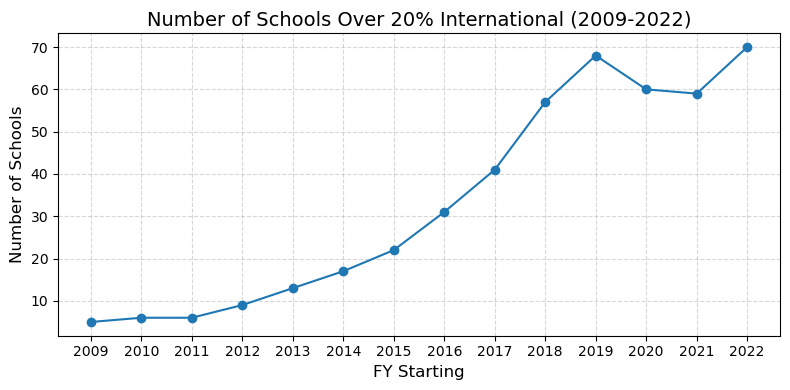

In [ ]:
import matplotlib.pyplot as plt

# Initialize an empty list to store the number of schools for each year
years = list(range(2009, 2023))  # List of years from 2009 to 2022
schools_passing = []

# Loop through each year and calculate the number of schools that passed 20% international enrolment
for year in years:
    passed_count = combined_df[
        (combined_df['FY Start'] == year) &
        (combined_df['% International'] > 20) &
        (combined_df['Francophone'] == 0) &
        (~combined_df['School Name'].str.contains("Total|Average"))
    ].shape[0]
    schools_passing.append(passed_count)

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(years, schools_passing, marker='o', linestyle='-')
plt.title('Number of Schools Over 20% International (2009-2022)', fontsize=14)
plt.xlabel('FY Starting', fontsize=12)
plt.ylabel('Number of Schools', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.xticks(years)  # Ensure all years are shown on the x-axis
plt.tight_layout()
plt.show()

In [ ]:
# The pre-Covid peak was 2019. How many schools?
combined_df[
    (combined_df['FY Start'] == 2019) &
    (combined_df['% International'] > 20) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['School Name'].str.contains("Total|Average"))
].shape

(68, 7)

As you can see, 2021 is actually a two-year low from **the peak in 2019, where 66 schools** already had more than 20% international students.

When we looked at raw international student numbers across Canada earlier though, the number of students admitted increased by 20,000 from 2020 to 2021. If we know:

- The number of schools with 20% international enrolment went down slightly from 20/21 to 21/22 and
- Domestic enrolment has virtualy flatlined - but confirm the numbers for 2019-2022 below

Where did the extra 30k international students go? Are they enrolling at schools already above this threshold?

In [ ]:
combined_df[
    combined_df['FY Start'].isin([2019, 2020, 2021])
][['International Enrolment', 'Domestic Enrolment']]

International Enrolment  Domestic Enrolment
10                        504                3039
11                        435                2991
12                        390                3123
24                         81                1005
25                         90                 972
...                       ...                 ...
3460                     1896                4734
3461                       12                   9
3462                     1923                4881
3463                       24                   6
3464                     1905                5022

[743 rows x 2 columns]

In [ ]:
# confirm the assumption above - total domestic enrolment from 20/21 to 21/22
canada_domestic[
    canada_domestic['FY Start'].isin([2019, 2020, 2021])
][['FY Start', 'Status', 'Enrolment']]



FY Start             Status  Enrolment
10      2019  Canadian students    1349823
11      2020  Canadian students    1357824
12      2021  Canadian students    1347282

In [ ]:
# the same code above for international enrolment
canada_data[
    canada_data['FY Start'].isin([2019, 2020, 2021])
][['FY Start', 'Status', 'Enrolment']]


FY Start                  Status  Enrolment
10      2019  International students     340227
11      2020  International students     329334
12      2021  International students     360162

That is confirming that around 1,200 domestic students were lost from AY 20/21 to 21/22, whilst nearly 31,000 international students were gained, whilst less institutions were above 20% international

So where did they go?

In [ ]:
# specific provinces change in International Students from 20/21 to 21/22
combined_df['Province/Territory'].unique()

# group international and domestic enrolment by province in the fiscal year 20/21 and 21/21
province_20_to_21 = combined_df[
    combined_df['FY Start'].isin([2019, 2020, 2021]) &
    (combined_df['Francophone'] == 0)
].groupby(['Province/Territory', 'FY Start'])[['International Enrolment', 'Domestic Enrolment']].sum()

province_20_to_21

International Enrolment  \
Province/Territory        FY Start                            
Alberta                   2019                        46728   
                          2020                        45282   
                          2021                        48786   
British Columbia          2019                       108462   
                          2020                        97842   
                          2021                        96504   
Manitoba                  2019                        19236   
                          2020                        18960   
                          2021                        21378   
New Brunswick             2019                         5118   
                          2020                         4608   
                          2021                         5946   
Newfoundland and Labrador 2019                         7458   
                          2020                         7398   
                          2021                         6630   
Nova Scotia               2019                        21852   
                          2020                        20436   
                          2021                        19560   
Ontario                   2019                       341016   
                          2020                       342756   
                          2021                       388290   
Prince Edward Island      2019                         3792   
                          2020                         3846   
                          2021                         3810   
Quebec                    2019                        30990   
                          2020                        29268   
                          2021                        28983   
Saskatchewan              2019                        12252   
                          2020                        11556   
                          2021                        12048   

                                    Domestic Enrolment  
Province/Territory        FY Start                      
Alberta                   2019                  303918  
                          2020                  306222  
                          2021                  309732  
British Columbia          2019                  251394  
                          2020                  252888  
                          2021                  250854  
Manitoba                  2019                   80730  
                          2020                   78870  
                          2021                   78762  
New Brunswick             2019                   28182  
                          2020                   27162  
                          2021                   27300  
Newfoundland and Labrador 2019                   32064  
                          2020                   32142  
                          2021                   32868  
Nova Scotia               2019                   70230  
                          2020                   70410  
                          2021                   75648  
Ontario                   2019                 1131378  
                          2020                 1124508  
                          2021                 1110798  
Prince Edward Island      2019                    9468  
                          2020                    9762  
                          2021                   10044  
Quebec                    2019                   66546  
                          2020                   68523  
                          2021                   68919  
Saskatchewan              2019                   71736  
                          2020                   71448  
                          2021                   71400

In the above, running down the list you can see for 20/21 to 21/22:
- Alberta added 3.5k International students
- BC slipped 1,300, so did NB 
    - BC was noticeably the biggest hit in international enrolment from 19/20 to 20/21, losing over 10,000 students
- Manitoba added 3,000
- NL dropped a few hundred, as did QC and SK
- NS lost 1,000
- Ontario added 45,000
- PEI was steady

The numbers don't appear to line up with a net gain of 31k, Ontario alone added 14k more, but these figures aren't in conflict with the number of institutions over 20% slightly decreasing from FY 20/21 to 21/22. The only way this makes sense is that the schools already past this threshold were the ones adding more enrolment during the pandemic.

Let's check the 2021 schools over 20% and where they were in 2019 - were they below the threshold still accelerating, or were they already there but stalled by covid?

In [ ]:
# Step 1: Identify the schools that were above the 20% Int'l in 2021
schools_above_20_in_2021 = combined_df[(combined_df['FY Start'] == 2021) & (combined_df['% International'] > 20) & (combined_df['Francophone'] == 0) & (~combined_df['School Name'].str.contains("Total|Average"))
]['School Name'].unique()

# Step 2: Retrieve the 2021 Percentages for these schools
percentages_2021 = combined_df[(combined_df['FY Start'] == 2021) & (combined_df['School Name'].isin(schools_above_20_in_2021))
][['School Name', '% International']].rename(columns={'% International': '% Intl 2021'})

# Step 3: Retrieve the 2019 percentages for the same schools
percentages_2019 = combined_df[(combined_df['FY Start'] == 2019) & (combined_df['School Name'].isin(schools_above_20_in_2021))
][['School Name', '% International']].rename(columns={'% International': '% Intl 2019'})

# Step 4: Merge the 2019 and 2021 percentages to calculate the change
percent_change = pd.merge(percentages_2019, percentages_2021, on='School Name', how='inner')
percent_change['Change in %'] = percent_change['% Intl 2021'] - percent_change['% Intl 2019']

# Display the result
percent_change.sort_values(by='Change in %', ascending=False)

School Name  % Intl 2019  % Intl 2021  \
5                           Canadore College        38.57        74.77   
27                          Loyalist College        36.84        69.23   
42                             Sault College        26.85        58.26   
47                         St. Clair College        20.40        47.42   
24           Kwantlen Polytechnic University        32.26        44.73   
25                           Lambton College        72.53        84.70   
0                          Algoma University        56.61        68.06   
57               Vancouver Community College        40.87        50.52   
9                     Coast Mountain College        47.23        56.22   
44                            Seneca College        37.10        45.28   
12                         Conestoga College        49.38        56.32   
32                    Niagara College Canada        33.78        40.50   
48                      St. Lawrence College        41.99        48.34   
4                           Cambrian College        52.51        58.81   
33                          NorQuest College        18.95        23.46   
37                           OCAD University        24.07        28.11   
16   Emily Carr University of Art and Design        29.84        33.33   
54                     University of Toronto        25.62        28.92   
56                     University of Windsor        23.29        26.21   
31           New Brunswick Community College        20.67        23.57   
36                   Northern Lights College        52.72        55.56   
20                          Georgian College        32.16        34.84   
52  University of Ottawa-Université d'Ottawa        19.60        21.77   
19                      George Brown College        25.50        27.52   
51                    University of Manitoba        21.33        23.24   
17                          Fanshawe College        32.52        34.17   
39             Red River College Polytechnic        26.08        27.65   
22               Humber College North Campus        24.43        25.90   
53        University of Prince Edward Island        29.22        30.39   
29            Mount Saint Vincent University        23.40        24.30   
58                           York University        19.30        20.03   
26                           Langara College        47.18        47.80   
3                          Burman University        20.41        20.72   
1              Assiniboine Community College        22.78        22.89   
50            University of British Columbia        28.38        27.90   
13                     Confederation College        23.49        22.91   
55                    University of Waterloo        23.13        22.51   
11                      Concordia University        26.75        26.01   
46                   Simon Fraser University        22.85        22.01   
2                         Bow Valley College        24.88        23.15   
14                      Dalhousie University        25.17        23.44   
28                         McGill University        34.21        31.51   
35                          Northern College        78.92        76.02   
43                           Selkirk College        44.85        41.76   
41                   Saint Mary's University        34.59        31.49   
23     Justice Institute of British Columbia        35.67        32.44   
15                           Douglas College        37.92        34.54   
49                Thompson Rivers University        42.14        38.63   
45  Sheridan College Institute of Technology        32.83        27.39   
18                           Fleming College        30.25        24.34   
21                           Holland College        27.50        20.99   
30                          NSCAD University        28.92        21.59   
8                         Centennial College        51.53        43.75   
38                          Okanagan 

In [ ]:
print(f"Of the 58 schools over 20% in 2021, {percent_change[percent_change['% Intl 2019'] > 20].shape[0]} were already over in 2019")
print(f"Of the 58 schools over 20% in 2021, {percent_change[percent_change['% Intl 2019'] > 33].shape[0]} were already over 33% in 2019")
print(f"Of the 58 schools over 20% in 2021, {percent_change[percent_change['% Intl 2019'] > 50].shape[0]} were already over 50% in 2019")

Of the 58 schools over 20% in 2021, 56 were already over in 2019
Of the 58 schools over 20% in 2021, 26 were already over 33% in 2019
Of the 58 schools over 20% in 2021, 8 were already over 50% in 2019


**The picture emerging is that the schools that had leaned into international the most by 2021 had already done so by 2019.** COVID-19 either substantially reversed that large increase between 2011 and 2019, or they punched straight through it, presumably by online offerings in the interim.

Below we look at the schools that held steady in composition during the COVID pandemic:

In [ ]:
# Schools that did not swing by more than 5 percent
steady_schools = percent_change[
    (percent_change['Change in %'] >= -10) &
    (percent_change['Change in %'] <= 10)
]
steady_schools.shape

(48, 4)

In [ ]:
# Schools that increased, or decreased by more than 5 percent between 2019 and 2021
swing_schools = percent_change[
    (percent_change['Change in %'] < -10) |
    (percent_change['Change in %'] > 10)
]

print(swing_schools.shape)
swing_schools.sort_values(by='Change in %', ascending=False)

(11, 4)


School Name  % Intl 2019  % Intl 2021  Change in %
5                  Canadore College        38.57        74.77        36.20
27                 Loyalist College        36.84        69.23        32.39
42                    Sault College        26.85        58.26        31.41
47                St. Clair College        20.40        47.42        27.02
24  Kwantlen Polytechnic University        32.26        44.73        12.47
25                  Lambton College        72.53        84.70        12.17
0                 Algoma University        56.61        68.06        11.45
40           Royal Roads University        45.31        33.82       -11.49
6            Cape Breton University        61.99        49.05       -12.94
34             North Island College        35.29        21.64       -13.65
10         College of New Caledonia        56.54        39.50       -17.04

In the schools that shifted more than 10% in international composition during the pandemic, up or down, more schools shifted up than shifted down, despite the difficulties in travel and study restrictions during this period.

It's noticeable that the up swingers are generally in Ontario whilst the down swing is more in BC, possibly reflecting different provincial public health policies in addition to the postsecondary institutions individual operations

The overall conclusion of the COVID pandemic (particularly 20/21 and partially 21/22 AY) is that the schools which changed their International/Domestic ratio most significantly were most significantly changed during this period, whether they continued to ramp up international enrollment significantly or that it declined most significantly, as in 4 of the 5 hardest declines fro 2019-2021 were over half international in 2019.

And as we examine these schools, a reminder all the other PSIs in the Canadian ecosystem are still below one in five in 2021.

I will add the A/Y 2022-23 to this data soon to see changes

### Some small schools **exploded** into international growth

I used a 20% international student ratio as a marker of schools that serve a significant international student populace relative to their size. 

Six schools were there in 2011, 57 were there in 2021 as discussed above, but a lot of schools went well beyond the one in five 'lower boundary'. 

Below we can see 28 of those went above 33% International

In [ ]:
# Half of the schools over 20% international in 2021 were already over 33%
combined_df[
    (combined_df['FY Start'] == 2021) &
    (combined_df['% International'] > 33) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['School Name'].str.contains("Total|Average"))
].shape

(28, 7)

Is there a pattern to where these schools are? Let's look at 2022, the most recent data. 

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot figure with two columns for the pie charts
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],  # Specify the type as 'domain' for pie charts
    subplot_titles=(
        'Location of Anglophone Canadian PSIs over 20% international, 2022',
        'Location of Anglophone Canadian PSIs over 33% international, 2022'
    )
)

# Filter the data for the first pie chart
data_25 = combined_df[
    (combined_df['FY Start'] == 2022) &
    (combined_df['% International'] > 20) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['School Name'].str.contains("Total|Average"))
]

# Filter the data for the second pie chart
data_50 = combined_df[
    (combined_df['FY Start'] == 2022) &
    (combined_df['% International'] > 33) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['School Name'].str.contains("Total|Average"))
]

# Add the first pie chart to the subplot
fig.add_trace(
    go.Pie(
        labels=data_25['Province/Territory'],
        title='>20% Int\'l',
        textinfo='percent+label',
        hole=0.3  # Optional: make it a donut chart
    ),
    row=1, col=1
)

# Add the second pie chart to the subplot
fig.add_trace(
    go.Pie(
        labels=data_50['Province/Territory'],
        title='>33% Int\'l',
        textinfo='percent+label',
        hole=0.3  # Optional: make it a donut chart
    ),
    row=1, col=2
)

# Update the layout of the figure
fig.update_layout(
    template='plotly_dark'
)

# Show the figure
fig.show()

In [ ]:
combined_df[(combined_df['FY Start'] == 2022) & (combined_df['% International'] > 33) & (~combined_df['School Name'].str.contains("Total|Average")) & (combined_df['Francophone'] == 0)]

School Name Province/Territory  FY Start  \
41                           Algoma University            Ontario      2022   
83               Assiniboine Community College           Manitoba      2022   
220                           Cambrian College            Ontario      2022   
276                           Canadore College            Ontario      2022   
290                     Cape Breton University        Nova Scotia      2022   
304                        Capilano University   British Columbia      2022   
346                         Centennial College            Ontario      2022   
374                     Coast Mountain College   British Columbia      2022   
388                   College of New Caledonia   British Columbia      2022   
785                          Conestoga College            Ontario      2022   
799                      Confederation College            Ontario      2022   
1478                           Douglas College   British Columbia      2022   
1506   Emily Carr University of Art and Design   British Columbia      2022   
1520                          Fanshawe College            Ontario      2022   
1534                           Fleming College            Ontario      2022   
1548                      George Brown College            Ontario      2022   
1562                          Georgian College            Ontario      2022   
1618               Humber College North Campus            Ontario      2022   
1674     Justice Institute of British Columbia   British Columbia      2022   
1707           Kwantlen Polytechnic University   British Columbia      2022   
1777                           Lambton College            Ontario      2022   
1791                           Langara College   British Columbia      2022   
1833                          Loyalist College            Ontario      2022   
2042                    Niagara College Canada            Ontario      2022   
2128                          Northern College            Ontario      2022   
2156                   Northern Lights College   British Columbia      2022   
2424                             Sault College            Ontario      2022   
2438                           Selkirk College   British Columbia      2022   
2452                            Seneca College            Ontario      2022   
2466  Sheridan College Institute of Technology            Ontario      2022   
2522                         St. Clair College            Ontario      2022   
2550                      St. Lawrence College            Ontario      2022   
2632                Thompson Rivers University   British Columbia      2022   
3126               Vancouver Community College   British Columbia      2022   

      Domestic Enrolment  International Enrolment  Francophone  \
41                   741                     2562            0   
83                  1176                      684            0   
220                 2601                     4803            0   
276                 1782                     4956            0   
290                 1428                     3330            0   
304                 3213                     2082            0   
346                 8298                    11559            0   
374                  246                      387            0   
388                 1095                      825            0   
785                 7788                    14292            0   
799                 1866                      945            0   
1478                6087                     3534            0   
1506                1248                      669            0   
1520               10386                     8172            0   
1534                2769                     2019            0   
1548               10821                     5391            0   
1562                5154                     7584            0   
1618               14733                     7584            0   
1674           

How extensive has the transition been in some schools?

Below are the schools **over 50% international**.

In [ ]:
# schools with >1.0 int/dom ratio in 2022
combined_df[
    (combined_df['FY Start'] == 2022) &
    (combined_df['% International'] > 50) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['School Name'].str.contains("Total|Average"))
]

School Name Province/Territory  FY Start  \
41                  Algoma University            Ontario      2022   
220                  Cambrian College            Ontario      2022   
276                  Canadore College            Ontario      2022   
290            Cape Breton University        Nova Scotia      2022   
346                Centennial College            Ontario      2022   
374            Coast Mountain College   British Columbia      2022   
785                 Conestoga College            Ontario      2022   
1562                 Georgian College            Ontario      2022   
1707  Kwantlen Polytechnic University   British Columbia      2022   
1777                  Lambton College            Ontario      2022   
1791                  Langara College   British Columbia      2022   
1833                 Loyalist College            Ontario      2022   
2042           Niagara College Canada            Ontario      2022   
2128                 Northern College            Ontario      2022   
2156          Northern Lights College   British Columbia      2022   
2424                    Sault College            Ontario      2022   
2452                   Seneca College            Ontario      2022   
2550             St. Lawrence College            Ontario      2022   
3126      Vancouver Community College   British Columbia      2022   

      Domestic Enrolment  International Enrolment  Francophone  \
41                   741                     2562            0   
220                 2601                     4803            0   
276                 1782                     4956            0   
290                 1428                     3330            0   
346                 8298                    11559            0   
374                  246                      387            0   
785                 7788                    14292            0   
1562                5154                     7584            0   
1707                5586                     5703            0   
1777                1794                    11736            0   
1791                3927                     4338            0   
1833                1602                     5049            0   
2042                4803                     8523            0   
2128                1119                     4164            0   
2156                 360                      540            0   
2424                1152                     2463            0   
2452               11298                    11346            0   
2550                4032                     6504            0   
3126                1041                     1404            0   

      % International  
41              77.57  
220             64.87  
276             73.55  
290             69.99  
346             58.21  
374             61.14  
785             64.73  
1562            59.54  
1707            50.52  
1777            86.74  
1791            52.49  
1833            75.91  
2042            63.96  
2128            78.82  
2156            60.00  
2424            68.13  
2452            50.11  
2550            61.73  
3126            57.42

These schools over 50% now have the majority of their operations for international students. There are a few things that make these schools noticeable:

- They are usually small colleges with enrolment in the 1,000-3,000 domestic mark that have enrolled that number or multiple times that number in international students in this ten year period. They **rapidly transformed** into predominantly international service providers.
- None of the original >20% ratio schools in 2011 are in this list.

For the most part, they started 2011 as small institutions that had next to no international student representation. In the period from 2011-2022 most of them declined domestically as they grew internationally.

In [ ]:
# look at the schools with over 50% in 2022 but in 2011
over_half_schools = combined_df[
    (combined_df['FY Start'] == 2022) &
    (combined_df['% International'] > 50) &
    (combined_df['Francophone'] == 0) &
    (~combined_df['School Name'].str.contains("Total|Average"))
]['School Name'].unique()

# Filter the data for these schools in 2011
combined_df[
    (combined_df['FY Start'] == 2011) &
    (combined_df['School Name'].isin(over_half_schools))
]

School Name Province/Territory  FY Start  \
30                  Algoma University            Ontario      2011   
209                  Cambrian College            Ontario      2011   
265                  Canadore College            Ontario      2011   
279            Cape Breton University        Nova Scotia      2011   
335                Centennial College            Ontario      2011   
363            Coast Mountain College   British Columbia      2011   
774                 Conestoga College            Ontario      2011   
1551                 Georgian College            Ontario      2011   
1696  Kwantlen Polytechnic University   British Columbia      2011   
1766                  Lambton College            Ontario      2011   
1780                  Langara College   British Columbia      2011   
1822                 Loyalist College            Ontario      2011   
2031           Niagara College Canada            Ontario      2011   
2117                 Northern College            Ontario      2011   
2145          Northern Lights College   British Columbia      2011   
2413                    Sault College            Ontario      2011   
2441                   Seneca College            Ontario      2011   
2539             St. Lawrence College            Ontario      2011   
3115      Vancouver Community College   British Columbia      2011   

      Domestic Enrolment  International Enrolment  Francophone  \
30                   819                       72            0   
209                 4194                       78            0   
265                 1287                      129            0   
279                 1899                      597            0   
335                 9651                     3375            0   
363                  642                        0            0   
774                 8886                      633            0   
1551                7362                      234            0   
1696                8220                      867            0   
1766                6858                      186            0   
1780                5697                      462            0   
1822                3108                       27            0   
2031                7248                      795            0   
2117                1308                        3            0   
2145                 411                       21            0   
2413                2346                        3            0   
2441               16761                      165            0   
2539                7206                      447            0   
3115                1536                      120            0   

      % International  
30               8.08  
209              1.83  
265              9.11  
279             23.92  
335             25.91  
363              0.00  
774              6.65  
1551             3.08  
1696             9.54  
1766             2.64  
1780             7.50  
1822             0.86  
2031             9.88  
2117             0.23  
2145             4.86  
2413             0.13  
2441             0.97  
2539             5.84  
3115             7.25

It is true that the smaller schools recruiting international students will have this ratio change more dramatically - TBC



#### Different provinces had different numbers of **'transformers'**

These are **initially small institutions in 2011 which had their international student % massively change in this 2011-2022 period.** They are distinct from:
- Schools which already began the period with a significant international student representation such as Centennial College, or 
- Those that added a lot of international students alongside a large domestic base like Seneca, Centennial, George Brown or York University. 

With domestic enrolment flatlined almost everywhere in Canada, it's not unreasonable that these previously small regional schools that have rapidly grown to multiples of their original size almost entirely off of international students. These schools are threatened the most with any restrictions to the flow of international students, as they cannot even rely on a sizeable domestic student populace to serve and receive funding.

**Ontario has the most explosive transformers** - Lambton College, Northern College, Canadore College, Algoma University, Cambrian College, Loyalist College and Conestoga College all began the period with at most 10% international student enrolment. With the exception of Conestoga College at 8000 domestic students, these were small sub-5000 student schools with 2011 international student numbers often in the hundreds. 

All of these schools entered 2021-22 with international students making at least the majorty of their student body, often multiple times the domestic count, like Lambton College which was around 85% international in 2021, and Algoma, Loyalist, Canadore and Northern College all above 67%.

- **Lambton College has strange data in 11-12 and 12-13 where Domestic enrolment then drops off a cliff for 13-14. I will check the MCU (provincial body) data for clarity, as it's more granular, but I suspect their domestic enrolment is around the 2-3k mark in 2011-2013.**
    
- **Cambrian College also had some early data in the MCU repository clouded by the 'Other' Category.**

**BC's transformers were not nearly as explosive as those in Ontario**. No BC institution passed 60% international by 2021 which was a lower boundary for the explosive growers in Ontario. In BC, Coast Mountain College (CMC), Northern Lights College, Langara College, College of New Caledonia (CNC) Kwantlen Polytechnic University (KPU), Vancouver Community College (VCC) and Selkirk College grew the highest share of international students in their makeup, all starting 2011 with < 10% international and all touched or exceeded 40% at some point in the most recent 3-4 years of the reference period. Some have peaked and dropped off like CNC, but it may be COVID related in 2020-2021.

- If we are trying to identify transformers as *small* schools that effectively changed their principal market from domestic to international, a *small school* is going to be smaller in BC than in ON by virtue of ON being nearly 3x the population. 
    - Langara began 2011 with 5,700 domestic students, KPU with 8,200 and this puts them in the category of  where the others were around 2,000 or below. Langara and KPU have both effectively become equal domestic and international students, closing a gap of 5.5-8k students.

    - Coast Mountain College and Northern Lights College are both sub-1000 domestic enrolment in 2011 so their ratios are going to be more sensitive to raw numbers.

Transformers were often but not always colleges - Cape Breton University, Algoma University and Kwantlen Polytechnic University all rapidly grew in international students with a small domestic base.

## Impact on Revenue - Tuition fees of schools, assuming declines in international enrolment due to IRCC changes

### Load dataset and introduction

From Statistics Canada: 
- [Canadian and international tuition fees by level of study (current dollars)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3710004501)

I did some spot checking and it does appear that undergraduate annual tuition fees are greater than (post)graduate, which I was surprised by.

This section will import the tuition fees table for 2023/24, as well as the number of graduate and undergraduate enrolments by international/domestic status. 

Since it was the 2023/2024 FY that the IRCC changes were announced (January 2024) this would be the most accurate point to project losses for postsecondary institutions, beginning with declines in enrolment for September 2024 and onwards, given further updates have occurred throughout 2024.

In a later version we may be able to see by number of permits issued specifically (when the data are available), but for now we will estimate based on hypothetical scenarios e.g. a blanket 15% or 25% decline for all institutions.

In [ ]:
# open the csv file
tuition = pd.read_csv('/Users/thomasdoherty/Desktop/canadian-psi-project/psi_data/statcan_data/23-24_fees.csv')

In [ ]:
tuition.drop(columns=['DGUID', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'], inplace=True)
tuition.head(15)

REF_DATE                        GEO               Level of study    VALUE
0   2023/2024                     Canada       Canadian undergraduate   7152.0
1   2023/2024                     Canada            Canadian graduate   7542.0
2   2023/2024                     Canada  International undergraduate  38251.0
3   2023/2024                     Canada       International graduate  22114.0
4   2023/2024  Newfoundland and Labrador       Canadian undergraduate   3593.0
5   2023/2024  Newfoundland and Labrador            Canadian graduate   3435.0
6   2023/2024  Newfoundland and Labrador  International undergraduate  17515.0
7   2023/2024  Newfoundland and Labrador       International graduate   4833.0
8   2023/2024       Prince Edward Island       Canadian undergraduate   7359.0
9   2023/2024       Prince Edward Island            Canadian graduate   5750.0
10  2023/2024       Prince Edward Island  International undergraduate  19128.0
11  2023/2024       Prince Edward Island       International graduate  11513.0
12  2023/2024                Nova Scotia       Canadian undergraduate   9551.0
13  2023/2024                Nova Scotia            Canadian graduate  10479.0
14  2023/2024                Nova Scotia  International undergraduate  25885.0

In [ ]:
# rename the columns for clarity
tuition.rename(columns={
    'REF_DATE': 'FY Start',
    'GEO': 'Province/Territory',
    'VALUE': 'Tuition Fees ($ CAD)'
}, inplace=True)

In [ ]:
# change format of FY start from xxxx/yyyy to xxxx
tuition['FY Start'] = tuition['FY Start'].str.split('/').str[0].astype(int)

In [ ]:
tuition.head()

FY Start         Province/Territory               Level of study  \
0      2023                     Canada       Canadian undergraduate   
1      2023                     Canada            Canadian graduate   
2      2023                     Canada  International undergraduate   
3      2023                     Canada       International graduate   
4      2023  Newfoundland and Labrador       Canadian undergraduate   

   Tuition Fees ($ CAD)  
0                7152.0  
1                7542.0  
2               38251.0  
3               22114.0  
4                3593.0

Adding enrolment by program types and international/domestic students from StatCan - [enrolment by program type and status of student in Canada](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3710027701). 

**Important notes**

- Classification of program types [is here](https://www23.statcan.gc.ca/imdb/p3VD.pl?Function=getVD&TVD=1252482&CVD=1252483&CLV=0&MLV=2&D=1). 
    - **Graduate (second cycle) means Master's programs**
    - **Graduate (third cycle) is PhD**

- **I'm using 2022-2023 enrolment data, and 2023/2024 tuition fee figures - latest available from StatCan**. We will use 2023-24 tuition fees, and enrolment from 22-23 with hypothetical declines in student enrolment due to IRCC changes made January 2024 to estimate revenue changes into the future.

- The easiest distinction is at Program Type, between undergraduate and graduate degrees for their tuition fee costs. However, you need to look at Credential Type for certificates and diplomas (popular at the colleges)
- There is inconsistency in where graduate diplomas/certificates sit in 'program type'.
    - For example there are 509,000 Credential type: Diploma students across all of Canada in 22/23 and 386k of them are in 'Career, Technical or Professional Training Program' Program Type. 85k of these are sitting under 'Pre-University Program' (of 87k total in the Pre-uni category) which makes me think there are PSIs classifying a High School diploma, which wouldn't impact tuition fees. The remaining 55k are scattered across various other program types
    - Certificate credentials are clearer - of 190k in Canada, almost all are captured in the 'Career, Technical or Professional Training Program', 'Post Career, Technical or Professional Training Program' or Undergraduate.
- I only imported the student enrolment from full programs - there were around 100,000 enrolments (out of 2.2m total enrolments in all programs) in 'non-program' some were non credit, some undergraduate, some graduate, I assume this meant students taking individual classes to complete programs at a later date, and not an end-to-end program enrolment on a schedule.
- The above analysis was done on full-time and part time students. As with my analysis earlier, I am only taking full-time PSI student data (a total of 1.7m in Canada)


All this is to say the calculations here will be estimates at best, with the heavy lifting being done by the difference between domestic and international tuition fees mostly at the undergraduate and graduate degree level, as these are the most numerous and require somewhat less granularity than fees for certificates/diplomas.

In [ ]:
# import the csv file
enrolment = pd.read_csv('/Users/thomasdoherty/Desktop/canadian-psi-project/psi_data/statcan_data/statcan-program-int-can-enrolment.csv')

In [ ]:
enrolment

REF_DATE                              GEO        DGUID  \
0     2022/2023        Newfoundland and Labrador  2021A000210   
1     2022/2023        Newfoundland and Labrador  2021A000210   
2     2022/2023        Newfoundland and Labrador  2021A000210   
3     2022/2023        Newfoundland and Labrador  2021A000210   
4     2022/2023        Newfoundland and Labrador  2021A000210   
...         ...                              ...          ...   
5017  2022/2023  Nunavut Arctic College, Nunavut          NaN   
5018  2022/2023  Nunavut Arctic College, Nunavut          NaN   
5019  2022/2023  Nunavut Arctic College, Nunavut          NaN   
5020  2022/2023  Nunavut Arctic College, Nunavut          NaN   
5021  2022/2023  Nunavut Arctic College, Nunavut          NaN   

             Field of study  \
0     Total, field of study   
1     Total, field of study   
2     Total, field of study   
3     Total, field of study   
4     Total, field of study   
...                     ...   
5017  Total, field of study   
5018  Total, field of study   
5019  Total, field of study   
5020  Total, field of study   
5021  Total, field of study   

                                           Program type  \
0                                   Total, program type   
1                                   Total, program type   
2                                   Total, program type   
3                                   Total, program type   
4                                   Total, program type   
...                                                 ...   
5017  Career, technical or professional training pro...   
5018  Career, technical or professional training pro...   
5019  Career, technical or professional training pro...   
5020                              Undergraduate program   
5021                              Undergraduate program   

                       Credential type          Institution type  \
0               Total, credential type  Total, institution type    
1               Total, credential type  Total, institution type    
2                          Certificate  Total, institution type    
3                          Certificate  Total, institution type    
4                              Diploma  Total, institution type    
...                                ...                       ...   
5017                       Certificate  Total, institution type    
5018                           Diploma  Total, institution type    
5019   Not applicable, credential type  Total, institution type    
5020            Total, credential type  Total, institution type    
5021  Degree (includes applied degree)  Total, institution type    

     Registration status Status of student in Canada         Gender  ...  \
0      Full-time student           Canadian students  Total, gender  ...   
1      Full-time student      International students  Total, gender  ...   
2      Full-time student           Canadian students  Total, gender  ...   
3      Full-time student      International students  Total, gender  ...   
4      Full-time student           Canadian students  Total, gender  ...   
...                  ...                         ...            ...  ...   
5017   Full-time student           Canadian students  Total, gender  ...   
5018   Full-time student           Canadian students  Total, gender  ...   
5019   Full-time student           Canadian students  Total, gender  ...   
5020   Full-time student           Canadian students  Total, gender  ...   
5021   Full-time student           Canadian students  Total, gender  ...   

     UOM_ID  SCALAR_FACTOR SCALAR_ID       VECTOR         COORDINATE  VALUE  \
0       223          units         0  v1608688340    2.1.1.1.1.2.2.1  15288   
1       223          units         0  v1608688344    2.1.1.1.1.2.3.1   4725   
2       223          units         0  v1608688462    2.1.1.3.1.2.2.1   1350   
3       223          units         0  v1608688466    2.1.1.3.1.2.3.1     42   
4       223        

### Cleaning of program-type enrolment

There's a few unnecessary columns and we will want to make sure the enrolment figures from the international/domestic students by school (earlier in this workbook) align with the program/credential type enrolment I am pulling in now. No reason why they should be different if we start with all programs/enrolment.

In [ ]:
# check registration status is all Full-time student
enrolment['Registration status'].unique()

array(['Full-time student'], dtype=object)

In [ ]:
# clean up a lot of columns
enrolment.drop(columns=['DGUID', 'Field of study', 'Registration status', 'Institution type', 'Gender', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'], inplace=True)

In [ ]:
enrolment

REF_DATE                              GEO  \
0     2022/2023        Newfoundland and Labrador   
1     2022/2023        Newfoundland and Labrador   
2     2022/2023        Newfoundland and Labrador   
3     2022/2023        Newfoundland and Labrador   
4     2022/2023        Newfoundland and Labrador   
...         ...                              ...   
5017  2022/2023  Nunavut Arctic College, Nunavut   
5018  2022/2023  Nunavut Arctic College, Nunavut   
5019  2022/2023  Nunavut Arctic College, Nunavut   
5020  2022/2023  Nunavut Arctic College, Nunavut   
5021  2022/2023  Nunavut Arctic College, Nunavut   

                                           Program type  \
0                                   Total, program type   
1                                   Total, program type   
2                                   Total, program type   
3                                   Total, program type   
4                                   Total, program type   
...                                                 ...   
5017  Career, technical or professional training pro...   
5018  Career, technical or professional training pro...   
5019  Career, technical or professional training pro...   
5020                              Undergraduate program   
5021                              Undergraduate program   

                       Credential type Status of student in Canada  VALUE  
0               Total, credential type           Canadian students  15288  
1               Total, credential type      International students   4725  
2                          Certificate           Canadian students   1350  
3                          Certificate      International students     42  
4                              Diploma           Canadian students   2895  
...                                ...                         ...    ...  
5017                       Certificate           Canadian students    312  
5018                           Diploma           Canadian students    294  
5019   Not applicable, credential type           Canadian students    123  
5020            Total, credential type           Canadian students     15  
5021  Degree (includes applied degree)           Canadian students     15  

[5022 rows x 6 columns]

In [ ]:
enrolment['Program type'].unique()

array(['Total, program type',
       'Career, technical or professional training program',
       'Post career, technical or professional training program',
       'Undergraduate program', 'Post-baccalaureate non-graduate program',
       'Graduate program (second cycle)',
       'Graduate program (third cycle)', 'Pre-university program'],
      dtype=object)

Cleaning & Processing still to do:
- Rename columns for clarity

- Nunavut/Yukon/NW Territories can be dropped

- Change Year entry to be consistent with previous, e.g. FY Start: 2022 rather than Year: 2022/2023

- Clean Institution name to Insitution and set Province in another category: e.g. York University rather than York University, Ontario

- Data Audit - do total enrolments in this data match up with the international / domestic data we have from earlier? It's the same student populations, they should be quite similar (some difference, because I have left out some less significant programs in the `enrolment` df)

- Some assumptions to be made regarding certificate/diploma being graduate or undergraduate programs

In [ ]:
# Renaming columns for clarity
enrolment.rename(columns={
    'REF_DATE': 'FY Start',
    'GEO': 'Institution',
    'VALUE': 'Enrolment',
    'Status of student in Canada': 'Student Status'
}, inplace=True)

In [ ]:
# check Yukon, Nunavut and Northwest Territories in the data to be dropped - confirm the small numbers we did not look at earlier

# create a list of territories to exclude
territories = ["Yukon", "Northwest Territories", "Nunavut"]

# drop the territories from Institution
enrolment = enrolment[~enrolment['Institution'].isin(territories)]

# drop the institutions in these territories by regex match after the comma in Institution
enrolment = enrolment[~enrolment['Institution'].str.contains("Yukon|Northwest Territories|Nunavut")]

In [ ]:
# spot check that Nunavut was removed
enrolment[enrolment['Institution'].str.contains("Nunavut")]

Empty DataFrame
Columns: [FY Start, Institution, Program type, Credential type, Student Status, Enrolment]
Index: []

In [ ]:
# create a province column after institution column, split on comma
enrolment['Province/Territory'] = enrolment['Institution'].str.split(',').str[1].str.strip()

# insert Province/Territory column after Institution
enrolment = enrolment[['FY Start', 'Institution', 'Province/Territory', 'Student Status', 'Program type', 'Credential type', 'Enrolment']]

# string replace Institution, remove comma and everything after
enrolment['Institution'] = enrolment['Institution'].str.replace(r',.*', '', regex=True)

In [ ]:
# Change FY Start from 2022/2023 to 2022
enrolment['FY Start'] = enrolment['FY Start'].str.split('/').str[0]

In [ ]:
enrolment

FY Start                      Institution Province/Territory  \
0        2022        Newfoundland and Labrador                NaN   
1        2022        Newfoundland and Labrador                NaN   
2        2022        Newfoundland and Labrador                NaN   
3        2022        Newfoundland and Labrador                NaN   
4        2022        Newfoundland and Labrador                NaN   
...       ...                              ...                ...   
4965     2022  University of the Fraser Valley   British Columbia   
4966     2022  University of the Fraser Valley   British Columbia   
4967     2022  University of the Fraser Valley   British Columbia   
4968     2022  University of the Fraser Valley   British Columbia   
4969     2022  University of the Fraser Valley   British Columbia   

              Student Status                             Program type  \
0          Canadian students                      Total, program type   
1     International students                      Total, program type   
2          Canadian students                      Total, program type   
3     International students                      Total, program type   
4          Canadian students                      Total, program type   
...                      ...                                      ...   
4965  International students                    Undergraduate program   
4966       Canadian students                    Undergraduate program   
4967  International students                    Undergraduate program   
4968  International students  Post-baccalaureate non-graduate program   
4969  International students  Post-baccalaureate non-graduate program   

                       Credential type  Enrolment  
0               Total, credential type      15288  
1               Total, credential type       4725  
2                          Certificate       1350  
3                          Certificate         42  
4                              Diploma       2895  
...                                ...        ...  
4965  Degree (includes applied degree)        729  
4966                  Associate degree         12  
4967                  Associate degree         84  
4968            Total, credential type         21  
4969                       Certificate         21  

[4970 rows x 7 columns]

#### Spot check the enrolment from this new table - couple of examples

In [ ]:
# spot check some enrolments - total enrolments against the combined df below
enrolment[(enrolment['Institution'] == 'York University') & (enrolment['Program type'] == 'Total, program type') & (enrolment['Credential type'] == 'Total, credential type')]

FY Start      Institution Province/Territory          Student Status  \
2558     2022  York University            Ontario       Canadian students   
2559     2022  York University            Ontario  International students   

             Program type         Credential type  Enrolment  
2558  Total, program type  Total, credential type      36144  
2559  Total, program type  Total, credential type       8697

In [ ]:
combined_df[(combined_df['School Name'] == 'York University') & (combined_df['FY Start'] == 2022)][['School Name', 'Domestic Enrolment', 'International Enrolment']]

School Name  Domestic Enrolment  International Enrolment
3182  York University               36144                     8697

In [ ]:
enrolment[(enrolment['Institution'] == 'University of British Columbia') & (enrolment['Program type'] == 'Total, program type') & (enrolment['Credential type'] == 'Total, credential type')]

FY Start                     Institution Province/Territory  \
4246     2022  University of British Columbia   British Columbia   
4247     2022  University of British Columbia   British Columbia   

              Student Status         Program type         Credential type  \
4246       Canadian students  Total, program type  Total, credential type   
4247  International students  Total, program type  Total, credential type   

      Enrolment  
4246      36735  
4247      14472

In [ ]:
combined_df[(combined_df['School Name'] == 'University of British Columbia') & (combined_df['FY Start'] == 2022)][['School Name', 'Domestic Enrolment', 'International Enrolment']]

School Name  Domestic Enrolment  \
2716  University of British Columbia               36735   

      International Enrolment  
2716                    14472

UBC and York both align so for now we can probably trust the numbers are good. We might see some discrepancies as we go on if we decide to drop certain program/credential types because they're very low enrolment and subject to some ambiguity.

### Calculate revenue

Things covered in this section:
- Combining the tuition fees from `tuition` dataframe with enrolment figures in `enrolment`
- Using tuition fees and 22/23 enrolment to calculate revenue from enrolment/tuition fees
- Projecting 23/24 enrolment based on international % growth rates and domestic enrolment changes, to provide some estimate of 23/24 enrolment all else being equal.
- Using hypothetical scenarios e.g. 10% drop in enrolment, 30% drop, 50% drop from international student enrolment to forecast & estimate revenue losses by school.

Notes:
- As we go forward, we should spot check enrolment in certain program types and credential types with the international enrolment from combined_df. There are probably going to be at least some inconsistencies in how a 'diploma' or 'certificate' is categorized and the average tuition fee values we're working with mean these will be informed estimates at best. But there should not be instances where specific programs / credentials have more enrolment than entire 'international' or 'domestic' students from combined_df.

## High-level conclusions:

Any relationship to population growth?

## Next Steps